In [1]:
import seaborn as sns
import pandas as pd
import re
import matplotlib as mpl
from matplotlib import rc
import missingno as msno
import warnings
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')

# matplotlib 한글 사용을 위한 코드
rc('font', family='AppleGothic')

In [2]:
final_df = pd.read_csv(
    '../../final_df_14/final_df_14.csv', encoding="cp949").drop(columns='Unnamed: 0')
X_train = pd.read_csv(
    '../../final_df_14/X_train_14.csv').drop(columns='Unnamed: 0')
y_train = pd.read_csv(
    '../../final_df_14/y_train_14.csv').drop(columns='Unnamed: 0')
X_test = pd.read_csv(
    '../../final_df_14/X_test_14.csv').drop(columns='Unnamed: 0')
y_test = pd.read_csv(
    '../../final_df_14/y_test_14.csv').drop(columns='Unnamed: 0')

In [3]:
# X_train.drop(columns=['aud_nationwide', 'log_aud'], inplace=True)
# X_test.drop(columns=['aud_nationwide', 'log_aud'], inplace=True)

In [4]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title                 925 non-null    object 
 1   director              925 non-null    object 
 2   distributor           925 non-null    object 
 3   distributor_group     925 non-null    object 
 4   release_date          925 non-null    int64  
 5   release_season        925 non-null    object 
 6   release               925 non-null    object 
 7   form                  925 non-null    object 
 8   nation                925 non-null    object 
 9   screen                925 non-null    int64  
 10  rev_nationwide        925 non-null    float64
 11  aud_nationwide        925 non-null    int64  
 12  rev_seoul             925 non-null    int64  
 13  rev_seoul.1           925 non-null    int64  
 14  genre                 925 non-null    object 
 15  rate                  9

In [5]:
len(X_train), len(X_test), len(y_train), len(y_test),

(740, 185, 740, 185)

In [6]:
df = pd.concat([X_train, y_train], axis=1)

In [7]:
len(df.columns)

35

In [8]:
df = df.drop(columns=['distributor_group', 'release', 'form',
                      'rev_nationwide', 'rev_seoul', 'rev_seoul.1', 'director_count'])

In [9]:
len(df.columns)

28

In [10]:
df.columns

Index(['title', 'director', 'distributor', 'release_date', 'release_season',
       'nation', 'screen', 'genre', 'rate', 'type', 'expert_rating',
       'starring_actors', 'running_times', 'audience_rating',
       'rating_audiences', 'realease_year', 'director_power', 'sequel',
       'original', 'actor_power', 'director_movie_count', 'actor_movie_count',
       'before_news', 'after_news', 'holiday', 'dist_cat', 'aud_nationwide',
       'log_aud'],
      dtype='object')

# 흐름
- screen, expert_rating, audience_rating, running_times, sequel, original, nation,  genre, rate, dist_cat
- actor_power, director_power
- before_news, after_news
- rating_audiences
- holiday
- 종속변수 로그
- 잔차 비선형성 제거
- 아웃라이어 제거
- news 피쳐의 변형


In [146]:
test_rsquare_arr = []

# model1
- 참고 논문들에서 사용한 독립변수들 사용
- 10개 피쳐들 단순 적용
    - screen, expert_rating, audience_rating, running_times, sequel, original, nation,  genre, rate, dist_cat


In [147]:
kfold_dict_learn = {}
kfold_dict = {}
kfold_dict_avr = []
RMSE_dict = {}
result_rsquare = {}
result_adj_rsquare = {}
kfold_df = pd.DataFrame()

In [148]:
df1 = df.copy()

In [149]:
# 10개의 독립변수 사용

feature_names = ['screen', 'expert_rating', 'audience_rating', 'running_times']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model1 = sm.OLS.from_formula(
    "aud_nationwide ~" + "+".join(feature_names), data=df1)
result1 = model1.fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:         aud_nationwide   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     45.92
Date:                Wed, 15 Apr 2020   Prob (F-statistic):          6.80e-142
Time:                        17:00:08   Log-Likelihood:                -11405.
No. Observations:                 740   AIC:                         2.287e+04
Df Residuals:                     710   BIC:                         2.301e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               7.57

In [150]:
# kfold 1

from sklearn.model_selection import KFold

kfold_dict_learn['1'] = []
kfold_dict['1'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df1)):
    df_train = df1.iloc[idx_train]
    df_test = df1.iloc[idx_test]

    model = sm.OLS.from_formula(
        "aud_nationwide ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'dist_cat',
                                   'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['aud_nationwide'] - pred) ** 2).sum()
    tss = ((df_test['aud_nationwide'] -
            df_test['aud_nationwide'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict_learn['1'].append(result.rsquared)
    kfold_dict['1'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['1'])/10)

학습 R2 = 0.65211451, 검증 R2 = 0.64305748
학습 R2 = 0.64854685, 검증 R2 = 0.68184139
학습 R2 = 0.64333485, 검증 R2 = 0.67402159
학습 R2 = 0.65503339, 검증 R2 = 0.60839195
학습 R2 = 0.65137804, 검증 R2 = 0.63919861
학습 R2 = 0.64319284, 검증 R2 = 0.72309674
학습 R2 = 0.65757770, 검증 R2 = 0.58053591
학습 R2 = 0.68605278, 검증 R2 = 0.36103947
학습 R2 = 0.65555049, 검증 R2 = 0.57760004
학습 R2 = 0.64081401, 검증 R2 = 0.69909107


In [151]:
# model1의 테스트 R

pred = result1.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'dist_cat',
                               'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['aud_nationwide'] - pred) ** 2).sum()
tss = ((y_test['aud_nationwide'] - y_test['aud_nationwide'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.6063840307534749

In [152]:
pred = result1.predict(X_test)
print('Mean_Squared_Error = ', mean_squared_error(
    pred, y_test['aud_nationwide']))
print('RMSE = ', mean_squared_error(pred, y_test['aud_nationwide'])**0.5)
RMSE_dict['1'] = mean_squared_error(pred, y_test['aud_nationwide'])**0.5

Mean_Squared_Error =  1480648594999.2756
RMSE =  1216819.0477631732


In [153]:
result_rsquare['result1_rsquared'] = result1.rsquared
result_adj_rsquare['result1_adj_rsquared'] = result1.rsquared_adj

In [154]:
test_rsquare_arr.append(0.6063840307534749)

# model2
- actor_power, director_power 추가

In [155]:
df2 = df1.copy()

In [156]:
# 12개의 독립변수 사용

feature_names = ['screen', 'expert_rating', 'audience_rating',
                 'running_times', 'actor_power', 'director_power']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model2 = sm.OLS.from_formula(
    "aud_nationwide ~" + "+".join(feature_names), data=df2)
result2 = model2.fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:         aud_nationwide   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     45.53
Date:                Wed, 15 Apr 2020   Prob (F-statistic):          2.76e-146
Time:                        17:00:09   Log-Likelihood:                -11390.
No. Observations:                 740   AIC:                         2.284e+04
Df Residuals:                     708   BIC:                         2.299e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               7.60

In [157]:
# kfold 2

from sklearn.model_selection import KFold

kfold_dict_learn['2'] = []
kfold_dict['2'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df2)):
    df_train = df2.iloc[idx_train]
    df_test = df2.iloc[idx_test]

    model = sm.OLS.from_formula(
        "aud_nationwide ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'dist_cat',
                                   'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['aud_nationwide'] - pred) ** 2).sum()
    tss = ((df_test['aud_nationwide'] -
            df_test['aud_nationwide'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict_learn['2'].append(result.rsquared)
    kfold_dict['2'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['2'])/10)

학습 R2 = 0.66498141, 검증 R2 = 0.66241464
학습 R2 = 0.66401365, 검증 R2 = 0.67229819
학습 R2 = 0.65411530, 검증 R2 = 0.70154754
학습 R2 = 0.66651418, 검증 R2 = 0.65086356
학습 R2 = 0.66730639, 검증 R2 = 0.60629479
학습 R2 = 0.65840796, 검증 R2 = 0.71739871
학습 R2 = 0.67264766, 검증 R2 = 0.57948672
학습 R2 = 0.69427664, 검증 R2 = 0.41135605
학습 R2 = 0.66997354, 검증 R2 = 0.58403934
학습 R2 = 0.66030769, 검증 R2 = 0.67135977


In [158]:
# model2의 테스트 R

pred = result2.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'dist_cat',
                               'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['aud_nationwide'] - pred) ** 2).sum()
tss = ((y_test['aud_nationwide'] - y_test['aud_nationwide'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.6243355959961607

In [159]:
test_rsquare_arr.append(0.6243355959961607)

In [160]:
pred = result2.predict(X_test)
print('Mean_Squared_Error = ', mean_squared_error(
    pred, y_test['aud_nationwide']))
print('RMSE = ', mean_squared_error(pred, y_test['aud_nationwide'])**0.5)
RMSE_dict['2'] = mean_squared_error(pred, y_test['aud_nationwide'])**0.5

Mean_Squared_Error =  1413120948939.841
RMSE =  1188747.638878766


In [161]:
result_rsquare['result2_rsquared'] = result2.rsquared
result_adj_rsquare['result2_adj_rsquared'] = result2.rsquared_adj

# model3
- before_news, after_news 추가

In [162]:
df3 = df2.copy()

In [163]:
# 14개의 독립변수 사용

feature_names = ['screen', 'expert_rating', 'audience_rating', 'running_times',
                 'actor_power', 'director_power', 'before_news', 'after_news']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model3 = sm.OLS.from_formula(
    "aud_nationwide ~" + "+".join(feature_names), data=df3)
result3 = model3.fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:         aud_nationwide   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     47.53
Date:                Wed, 15 Apr 2020   Prob (F-statistic):          1.20e-155
Time:                        17:00:11   Log-Likelihood:                -11363.
No. Observations:                 740   AIC:                         2.279e+04
Df Residuals:                     706   BIC:                         2.295e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               8.28

In [164]:
# kfold 3

from sklearn.model_selection import KFold

kfold_dict_learn['3'] = []
kfold_dict['3'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df3)):
    df_train = df3.iloc[idx_train]
    df_test = df3.iloc[idx_test]

    model = sm.OLS.from_formula(
        "aud_nationwide ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news', 'after_news', 'dist_cat',
                                   'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['aud_nationwide'] - pred) ** 2).sum()
    tss = ((df_test['aud_nationwide'] -
            df_test['aud_nationwide'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict_learn['3'].append(result.rsquared)
    kfold_dict['3'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['3'])/10)

학습 R2 = 0.68853920, 검증 R2 = 0.68673027
학습 R2 = 0.68284680, 검증 R2 = 0.76228227
학습 R2 = 0.68020463, 검증 R2 = 0.71321405
학습 R2 = 0.69279813, 검증 R2 = 0.64056900
학습 R2 = 0.69104915, 검증 R2 = 0.62879596
학습 R2 = 0.68664015, 검증 R2 = 0.68585173
학습 R2 = 0.68940175, 검증 R2 = 0.66769567
학습 R2 = 0.72118241, 검증 R2 = 0.40690405
학습 R2 = 0.69552578, 검증 R2 = 0.57533130
학습 R2 = 0.68324363, 검증 R2 = 0.69996448


In [165]:
# model3의 테스트 R

pred = result3.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news', 'after_news', 'dist_cat',
                               'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['aud_nationwide'] - pred) ** 2).sum()
tss = ((y_test['aud_nationwide'] - y_test['aud_nationwide'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.6445087799148355

In [166]:
test_rsquare_arr.append(0.6445087799148355)

In [167]:
pred = result3.predict(X_test)
print('Mean_Squared_Error = ', mean_squared_error(
    pred, y_test['aud_nationwide']))
print('RMSE = ', mean_squared_error(pred, y_test['aud_nationwide'])**0.5)
RMSE_dict['3'] = mean_squared_error(pred, y_test['aud_nationwide'])**0.5

Mean_Squared_Error =  1337236333579.7866
RMSE =  1156389.3520695297


In [168]:
result_rsquare['result3_rsquared'] = result3.rsquared
result_adj_rsquare['result3_adj_rsquared'] = result3.rsquared_adj

# model4
- rating_audiences 추가 

In [169]:
df4 = df3.copy()

In [170]:
# 15개의 독립변수 사용

feature_names = ['screen', 'expert_rating', 'audience_rating', 'running_times',
                 'actor_power', 'director_power', 'before_news', 'after_news', 'rating_audiences']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model4 = sm.OLS.from_formula(
    "aud_nationwide ~" + "+".join(feature_names), data=df4)
result4 = model4.fit()
print(result4.summary())

                            OLS Regression Results                            
Dep. Variable:         aud_nationwide   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     59.93
Date:                Wed, 15 Apr 2020   Prob (F-statistic):          3.69e-183
Time:                        17:00:13   Log-Likelihood:                -11293.
No. Observations:                 740   AIC:                         2.266e+04
Df Residuals:                     705   BIC:                         2.282e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                9

In [171]:
# kfold 4

from sklearn.model_selection import KFold

kfold_dict_learn['4'] = []
kfold_dict['4'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df4)):
    df_train = df4.iloc[idx_train]
    df_test = df4.iloc[idx_test]

    model = sm.OLS.from_formula(
        "aud_nationwide ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news', 'after_news', 'rating_audiences', 'dist_cat',
                                   'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['aud_nationwide'] - pred) ** 2).sum()
    tss = ((df_test['aud_nationwide'] -
            df_test['aud_nationwide'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict_learn['4'].append(result.rsquared)
    kfold_dict['4'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['4'])/10)

학습 R2 = 0.74325552, 검증 R2 = 0.73025309
학습 R2 = 0.73678227, 검증 R2 = 0.81312361
학습 R2 = 0.75912834, 검증 R2 = 0.49906999
학습 R2 = 0.74333416, 검증 R2 = 0.73092590
학습 R2 = 0.74130819, 검증 R2 = 0.75381165
학습 R2 = 0.73567343, 검증 R2 = 0.79679714
학습 R2 = 0.73169839, 검증 R2 = 0.84482117
학습 R2 = 0.77969845, 검증 R2 = 0.42026655
학습 R2 = 0.74538901, 검증 R2 = 0.68728025
학습 R2 = 0.73899896, 검증 R2 = 0.74426151


In [172]:
# model4의 테스트 R

pred = result4.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news', 'after_news', 'rating_audiences', 'dist_cat',
                               'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['aud_nationwide'] - pred) ** 2).sum()
tss = ((y_test['aud_nationwide'] - y_test['aud_nationwide'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.7048007034475638

In [173]:
test_rsquare_arr.append(0.7048007034475638)

In [174]:
pred = result4.predict(X_test)
print('Mean_Squared_Error = ', mean_squared_error(
    pred, y_test['aud_nationwide']))
print('RMSE = ', mean_squared_error(pred, y_test['aud_nationwide'])**0.5)
RMSE_dict['4'] = mean_squared_error(pred, y_test['aud_nationwide'])**0.5

Mean_Squared_Error =  1110438746989.4246
RMSE =  1053773.5748202384


In [175]:
result_rsquare['result4_rsquared'] = result4.rsquared
result_adj_rsquare['result4_adj_rsquared'] = result4.rsquared_adj

# model5
- holiday 추가

In [176]:
df5 = df4.copy()

In [177]:
# 16개의 독립변수 사용

feature_names = ['screen', 'expert_rating', 'audience_rating', 'running_times',
                 'actor_power', 'director_power', 'before_news', 'after_news', 'rating_audiences', 'holiday']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model5 = sm.OLS.from_formula(
    "aud_nationwide ~" + "+".join(feature_names), data=df5)
result5 = model5.fit()
print(result5.summary())

                            OLS Regression Results                            
Dep. Variable:         aud_nationwide   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     58.48
Date:                Wed, 15 Apr 2020   Prob (F-statistic):          6.53e-183
Time:                        17:00:15   Log-Likelihood:                -11292.
No. Observations:                 740   AIC:                         2.266e+04
Df Residuals:                     704   BIC:                         2.282e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                9

In [178]:
# kfold 5

from sklearn.model_selection import KFold

kfold_dict_learn['5'] = []
kfold_dict['5'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df5)):
    df_train = df5.iloc[idx_train]
    df_test = df5.iloc[idx_test]

    model = sm.OLS.from_formula(
        "aud_nationwide ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news', 'after_news', 'rating_audiences', 'holiday', 'dist_cat',
                                   'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['aud_nationwide'] - pred) ** 2).sum()
    tss = ((df_test['aud_nationwide'] -
            df_test['aud_nationwide'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict_learn['5'].append(result.rsquared)
    kfold_dict['5'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['5'])/10)

학습 R2 = 0.74416492, 검증 R2 = 0.73278592
학습 R2 = 0.73818246, 검증 R2 = 0.80929549
학습 R2 = 0.76002685, 검증 R2 = 0.50139675
학습 R2 = 0.74447553, 검증 R2 = 0.73195975
학습 R2 = 0.74316616, 검증 R2 = 0.73400369
학습 R2 = 0.73745404, 검증 R2 = 0.78923608
학습 R2 = 0.73249659, 검증 R2 = 0.84936533
학습 R2 = 0.78050370, 검증 R2 = 0.42367878
학습 R2 = 0.74670011, 검증 R2 = 0.68496689
학습 R2 = 0.73951747, 검증 R2 = 0.74795337


In [179]:
# model5의 테스트 R

pred = result5.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news', 'after_news', 'rating_audiences', 'holiday', 'dist_cat',
                               'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['aud_nationwide'] - pred) ** 2).sum()
tss = ((y_test['aud_nationwide'] - y_test['aud_nationwide'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.6990985325678981

In [180]:
test_rsquare_arr.append(0.6990985325678981)

In [181]:
pred = result5.predict(X_test)
print('Mean_Squared_Error = ', mean_squared_error(
    pred, y_test['aud_nationwide']))
print('RMSE = ', mean_squared_error(pred, y_test['aud_nationwide'])**0.5)
RMSE_dict['5'] = mean_squared_error(pred, y_test['aud_nationwide'])**0.5

Mean_Squared_Error =  1131888362759.8022
RMSE =  1063902.421634523


In [182]:
result_rsquare['result5_rsquared'] = result5.rsquared
result_adj_rsquare['result5_adj_rsquared'] = result5.rsquared_adj

# model6
- 종속변수에 log

In [183]:
df6 = df5.copy()

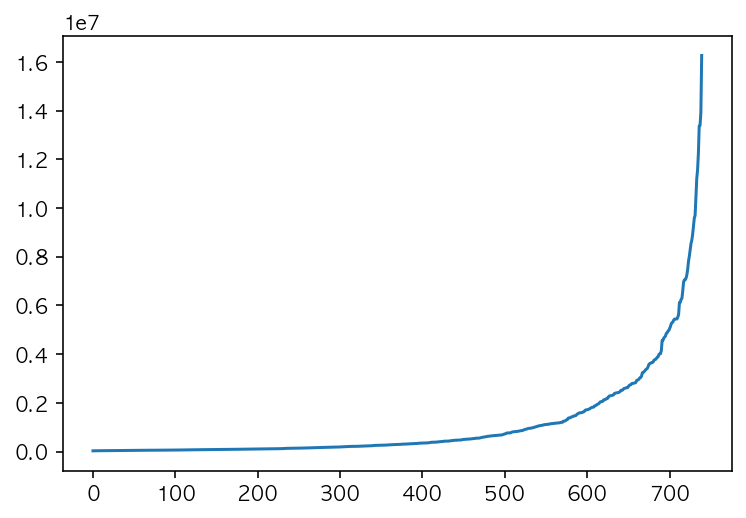

In [184]:
plt.plot(df6['aud_nationwide'].sort_values().reset_index(drop=True))

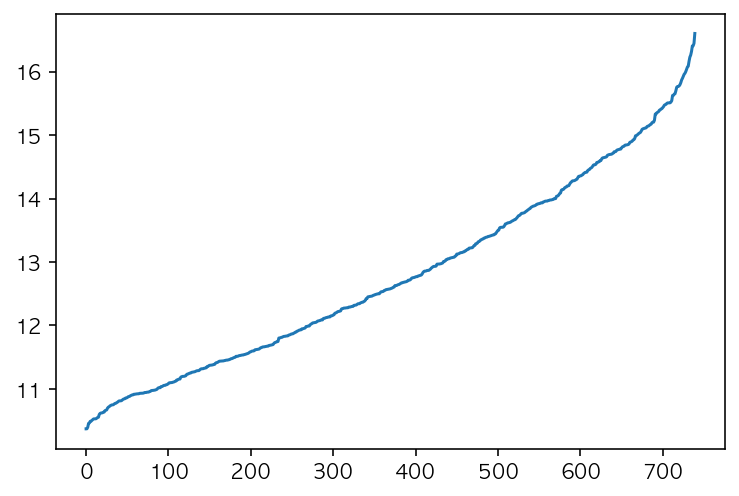

In [185]:
plt.plot(np.log(df6['aud_nationwide'].sort_values().reset_index(drop=True)))

In [186]:
# 16개의 독립변수 사용

feature_names = ['screen', 'expert_rating', 'audience_rating', 'running_times',
                 'actor_power', 'director_power', 'before_news', 'after_news', 'rating_audiences', 'holiday']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model6 = sm.OLS.from_formula(
    "log_aud ~" + "+".join(feature_names), data=df6)
result6 = model6.fit()
print(result6.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     73.10
Date:                Wed, 15 Apr 2020   Prob (F-statistic):          1.25e-208
Time:                        17:00:21   Log-Likelihood:                -780.17
No. Observations:                 740   AIC:                             1632.
Df Residuals:                     704   BIC:                             1798.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [187]:
# kfold 6

from sklearn.model_selection import KFold

kfold_dict_learn['6'] = []
kfold_dict['6'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df6)):
    df_train = df6.iloc[idx_train]
    df_test = df6.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news', 'after_news', 'rating_audiences', 'holiday', 'dist_cat',
                                   'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict_learn['6'].append(result.rsquared)
    kfold_dict['6'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['6'])/10)

학습 R2 = 0.78204344, 검증 R2 = 0.79079385
학습 R2 = 0.78587245, 검증 R2 = 0.74442310
학습 R2 = 0.78089355, 검증 R2 = 0.69765359
학습 R2 = 0.79094868, 검증 R2 = 0.71034140
학습 R2 = 0.78322373, 검증 R2 = 0.78212960
학습 R2 = 0.78699304, 검증 R2 = 0.73778184
학습 R2 = 0.78793671, 검증 R2 = 0.72369768
학습 R2 = 0.78691007, 검증 R2 = 0.74555826
학습 R2 = 0.78383108, 검증 R2 = 0.77178975
학습 R2 = 0.78948926, 검증 R2 = 0.72675976


In [188]:
# model6의 테스트 R

pred = result6.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news', 'after_news', 'rating_audiences', 'holiday', 'dist_cat',
                               'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.7439545187829606

In [189]:
test_rsquare_arr.append(0.7439545187829606)

In [190]:
pred = result6.predict(X_test)
print('Mean_Squared_Error = ', mean_squared_error(
    pred, y_test['aud_nationwide']))
print('RMSE = ', mean_squared_error(pred, y_test['aud_nationwide'])**0.5)
RMSE_dict['6'] = mean_squared_error(pred, y_test['aud_nationwide'])**0.5

Mean_Squared_Error =  4822243532563.353
RMSE =  2195960.731106855


In [191]:
result_rsquare['result6_rsquared'] = result6.rsquared
result_adj_rsquare['result6_adj_rsquared'] = result6.rsquared_adj

# model7
- 독립변수 잔차의 비선형성 제거
    - screen
    - rating_audiences -> 두번 적용
    - news 피쳐 처리

In [192]:
df7 = df6.copy()

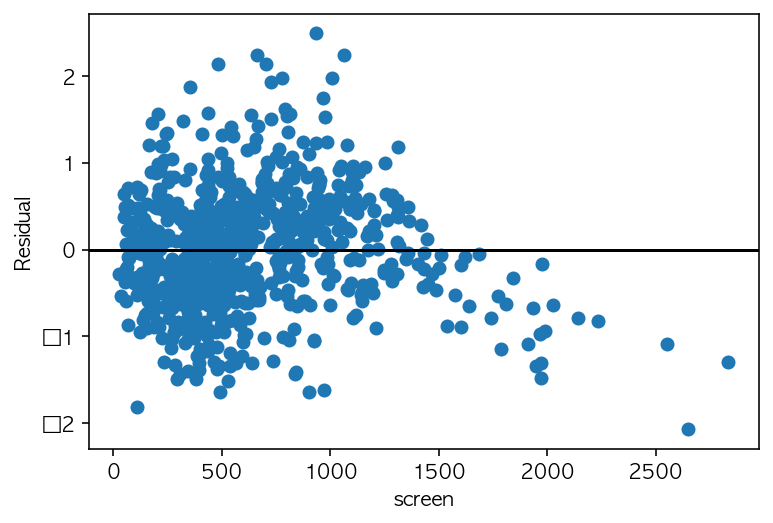

In [193]:
plt.plot(df7['screen'], result6.resid, 'o')
plt.axhline(y=0, c='k')
plt.xlabel("screen")
plt.ylabel("Residual")
plt.show()

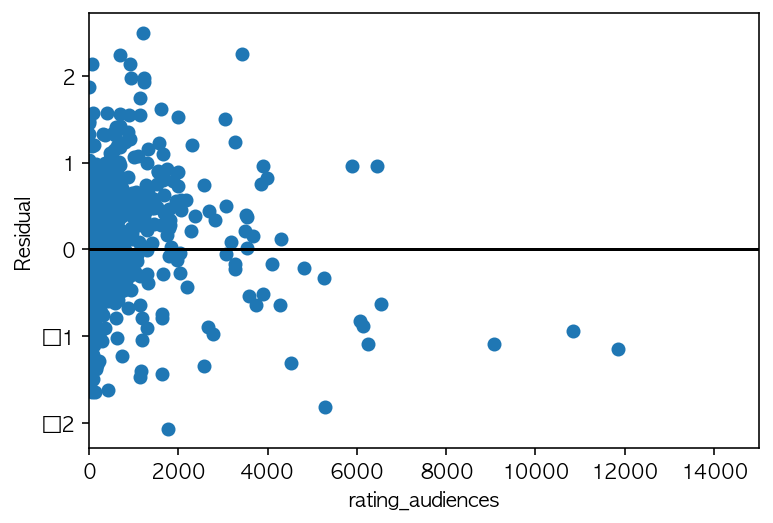

In [194]:
plt.plot(df7['rating_audiences'], result6.resid, 'o')
plt.axhline(y=0, c='k')
plt.xlabel("rating_audiences")
plt.ylabel("Residual")
plt.xlim(0, 15000)
plt.show()

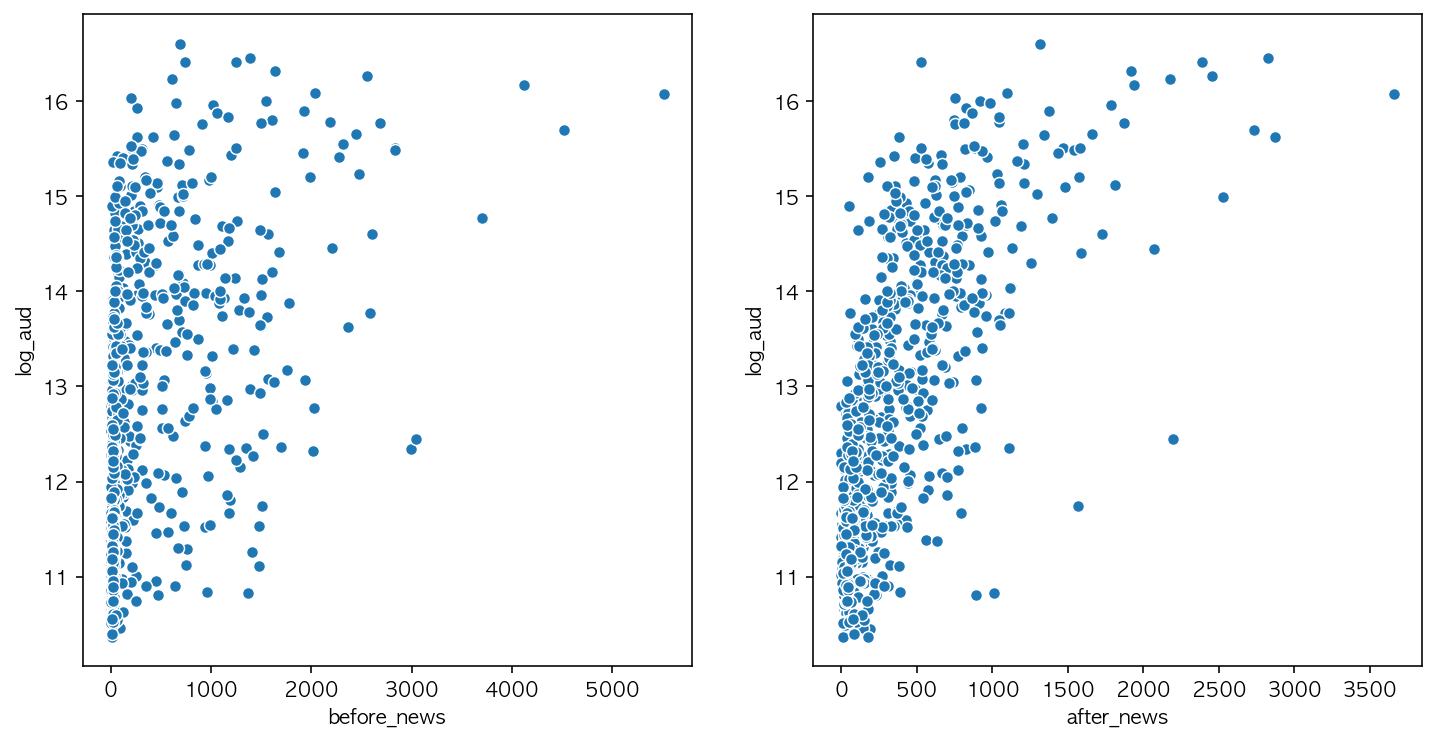

In [195]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.scatterplot(x="before_news", y="log_aud", data=df7)
plt.subplot(122)
sns.scatterplot(x="after_news", y="log_aud", data=df7)
plt.show()

In [196]:
df7['before_news_0to1'] = df7['before_news'].apply(
    lambda news: 1 if news == 0 else news)
df7['after_news_0to1'] = df7['after_news'].apply(
    lambda news: 1 if news == 0 else news)
df7['log_before_news'] = df7['before_news_0to1'].apply(
    lambda news: np.log(news))
df7['log_after_news'] = df7['after_news_0to1'].apply(
    lambda news: np.log(news))

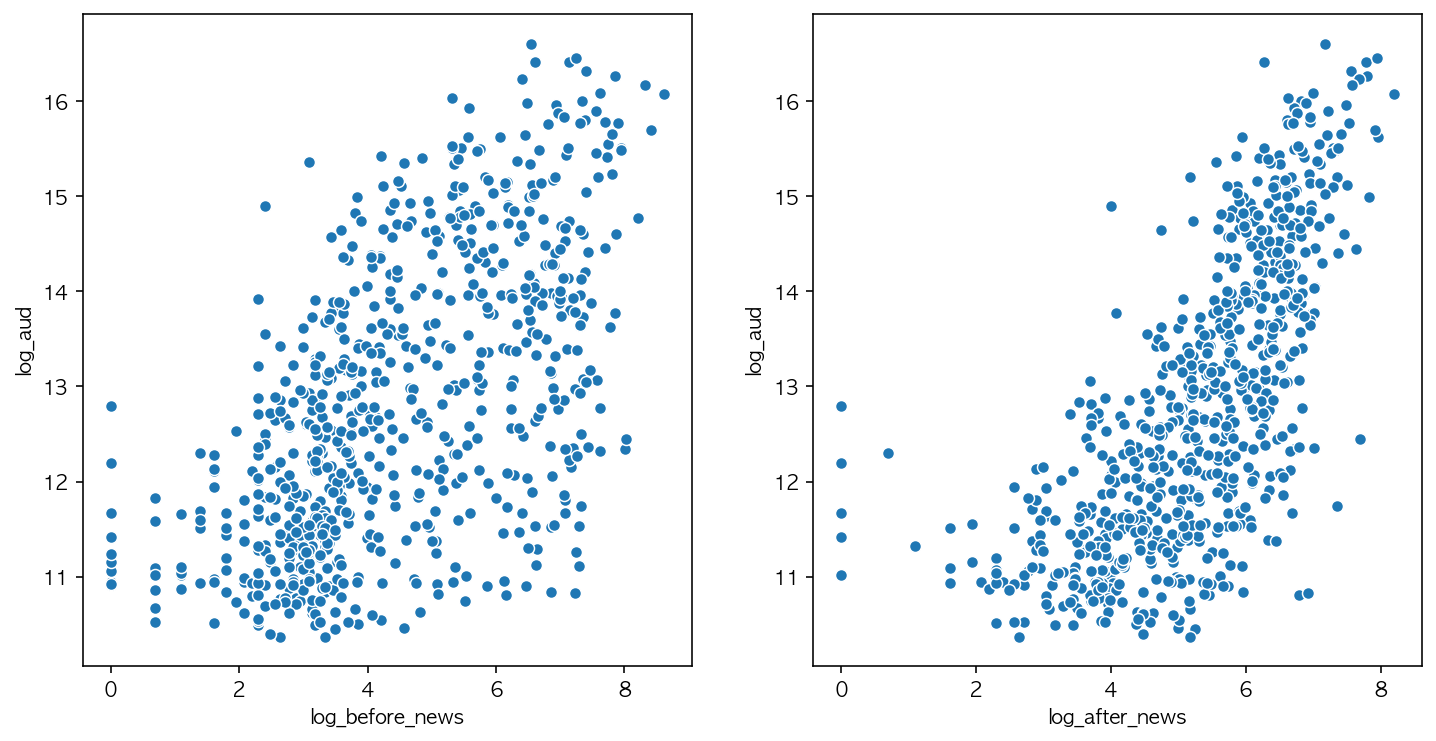

In [197]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.scatterplot(x="log_before_news", y="log_aud", data=df7)
plt.subplot(122)
sns.scatterplot(x="log_after_news", y="log_aud", data=df7)
plt.show()

In [198]:
# 16개의 독립변수 사용

feature_names = ['screen**(4/7)', 'expert_rating', 'audience_rating', 'running_times',
                 'actor_power', 'director_power', 'np.log(before_news_0to1)', 'np.log(after_news_0to1)', 'rating_audiences**(3/7)', 'rating_audiences**2', 'holiday']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model7 = sm.OLS.from_formula(
    "log_aud ~" + "+".join(feature_names), data=df7)
result7 = model7.fit()
print(result7.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     98.70
Date:                Wed, 15 Apr 2020   Prob (F-statistic):          4.91e-248
Time:                        17:00:25   Log-Likelihood:                -681.28
No. Observations:                 740   AIC:                             1437.
Df Residuals:                     703   BIC:                             1607.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [199]:
# kfold 7

from sklearn.model_selection import KFold

kfold_dict_learn['7'] = []
kfold_dict['7'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df7)):
    df_train = df7.iloc[idx_train]
    df_test = df7.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news_0to1', 'after_news_0to1', 'rating_audiences', 'holiday', 'dist_cat',
                                   'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict_learn['7'].append(result.rsquared)
    kfold_dict['7'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['7'])/10)

학습 R2 = 0.83223529, 검증 R2 = 0.84918888
학습 R2 = 0.83450924, 검증 R2 = 0.81732146
학습 R2 = 0.84182277, 검증 R2 = 0.23892310
학습 R2 = 0.83684563, 검증 R2 = 0.80940839
학습 R2 = 0.83543093, 검증 R2 = 0.81745260
학습 R2 = 0.84092448, 검증 R2 = 0.74852232
학습 R2 = 0.83809772, 검증 R2 = 0.78087933
학습 R2 = 0.83423871, 검증 R2 = 0.82991828
학습 R2 = 0.83403709, 검증 R2 = 0.83106733
학습 R2 = 0.83676056, 검증 R2 = 0.80607968


In [200]:
X_test['before_news_0to1'] = X_test['before_news'].apply(
    lambda news: 1 if news == 0 else news)
X_test['after_news_0to1'] = X_test['after_news'].apply(
    lambda news: 1 if news == 0 else news)

In [201]:
# model7의 테스트 R

pred = result7.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news_0to1', 'after_news_0to1', 'rating_audiences', 'holiday', 'dist_cat',
                               'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.815414989993791

In [202]:
test_rsquare_arr.append(0.815414989993791)

In [203]:
pred = result7.predict(X_test)
print('Mean_Squared_Error = ', mean_squared_error(
    pred, y_test['aud_nationwide']))
print('RMSE = ', mean_squared_error(pred, y_test['aud_nationwide'])**0.5)
RMSE_dict['7'] = mean_squared_error(pred, y_test['aud_nationwide'])**0.5

Mean_Squared_Error =  4822243320909.18
RMSE =  2195960.6829151516


In [204]:
result_rsquare['result7_rsquared'] = result7.rsquared
result_adj_rsquare['result7_adj_rsquared'] = result7.rsquared_adj

# model8
- 아웃라이어 제거 1
    - 576 어벤져스: 엔드게임

In [205]:
df8 = df7.copy()

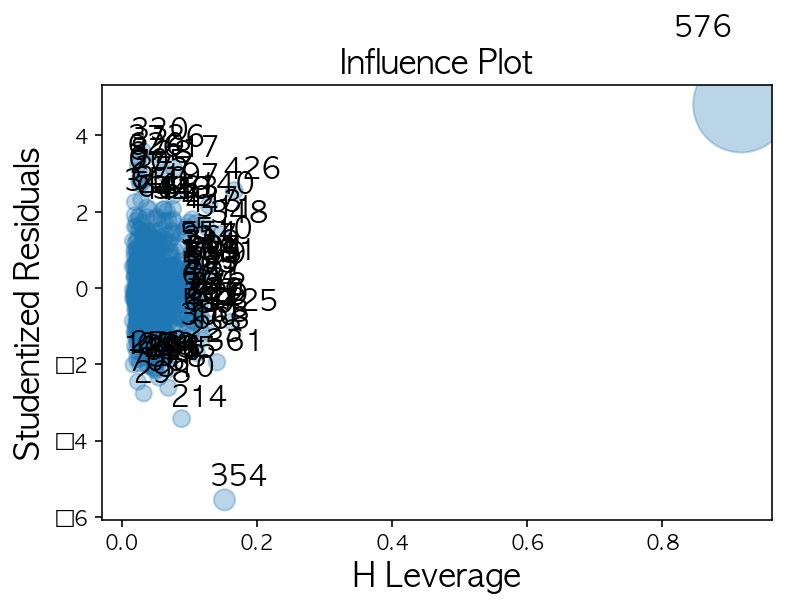

In [206]:
# Cook's distance

sm.graphics.influence_plot(result7, plot_alpha=0.3)
plt.show()

In [207]:
len(df8)

740

In [208]:
df8 = df8.drop(index=[576])

In [209]:
# df8.iloc[576]

In [210]:
len(df8)

739

In [211]:
# 16개의 독립변수 사용

feature_names = ['screen**(4/7)', 'expert_rating', 'audience_rating', 'running_times',
                 'actor_power', 'director_power', 'np.log(before_news_0to1)', 'np.log(after_news_0to1)', 'rating_audiences**(3/7)', 'rating_audiences**2', 'holiday']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model8 = sm.OLS.from_formula(
    "log_aud ~" + "+".join(feature_names), data=df8)
result8 = model8.fit()
print(result8.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     101.5
Date:                Wed, 15 Apr 2020   Prob (F-statistic):          2.49e-251
Time:                        17:00:29   Log-Likelihood:                -668.87
No. Observations:                 739   AIC:                             1412.
Df Residuals:                     702   BIC:                             1582.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [212]:
# kfold 8

from sklearn.model_selection import KFold

kfold_dict_learn['8'] = []
kfold_dict['8'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df8)):
    df_train = df8.iloc[idx_train]
    df_test = df8.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news_0to1', 'after_news_0to1', 'rating_audiences', 'holiday', 'dist_cat',
                                   'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict_learn['8'].append(result.rsquared)
    kfold_dict['8'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['8'])/10)

학습 R2 = 0.83458760, 검증 R2 = 0.86424640
학습 R2 = 0.83937546, 검증 R2 = 0.81458071
학습 R2 = 0.83959023, 검증 R2 = 0.79613489
학습 R2 = 0.84039201, 검증 R2 = 0.80866982
학습 R2 = 0.84375516, 검증 R2 = 0.77807521
학습 R2 = 0.84338996, 검증 R2 = 0.77215794
학습 R2 = 0.84657288, 검증 R2 = 0.67766957
학습 R2 = 0.83882499, 검증 R2 = 0.82974638
학습 R2 = 0.83806527, 검증 R2 = 0.83534338
학습 R2 = 0.83573181, 검증 R2 = 0.85147615


In [213]:
# model8의 테스트 R

pred = result8.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news_0to1', 'after_news_0to1', 'rating_audiences', 'holiday', 'dist_cat',
                               'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.822530762653385

In [214]:
test_rsquare_arr.append(0.822530762653385)

In [215]:
pred = result8.predict(X_test)
print('Mean_Squared_Error = ', mean_squared_error(
    pred, y_test['aud_nationwide']))
print('RMSE = ', mean_squared_error(pred, y_test['aud_nationwide'])**0.5)
RMSE_dict['8'] = mean_squared_error(pred, y_test['aud_nationwide'])**0.5

Mean_Squared_Error =  4822243317256.343
RMSE =  2195960.6820834344


In [216]:
result_rsquare['result8_rsquared'] = result8.rsquared
result_adj_rsquare['result8_adj_rsquared'] = result8.rsquared_adj

# model9
- 아웃라이어 제거 2
    - 39 부산행
    - 398 캡틴 아메리카: 시빌 워
    - 354 옥자
    - 426 벤허

In [217]:
df9 = df8.copy()

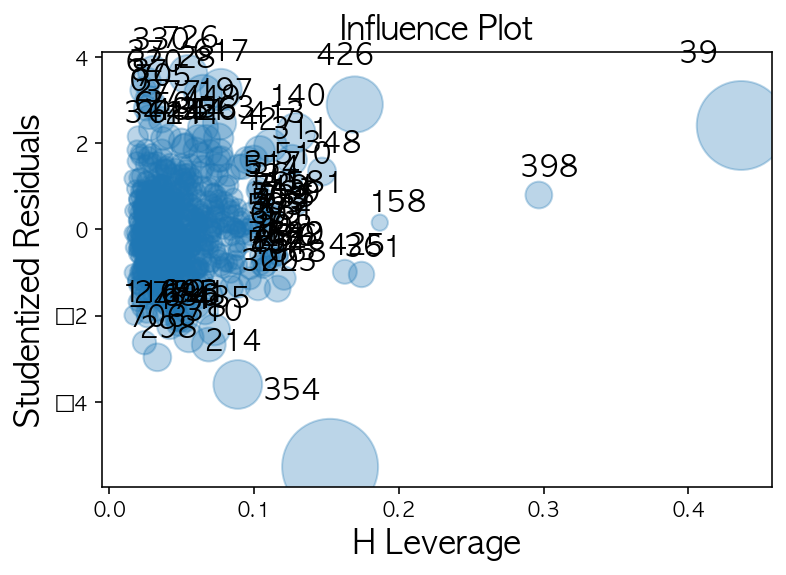

In [218]:
# Cook's distance

sm.graphics.influence_plot(result8, plot_alpha=0.3)
plt.show()

In [219]:
# df9.iloc[214]

In [220]:
df9 = df9.drop(index=[39, 398, 354, 426])

In [221]:
# 16개의 독립변수 사용

feature_names = ['screen**(4/7)', 'expert_rating', 'audience_rating', 'running_times',
                 'actor_power', 'director_power', 'np.log(before_news_0to1)', 'np.log(after_news_0to1)', 'rating_audiences**(3/7)', 'rating_audiences**2', 'holiday']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model9 = sm.OLS.from_formula(
    "log_aud ~" + "+".join(feature_names), data=df9)
result9 = model9.fit()
print(result9.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     106.9
Date:                Wed, 15 Apr 2020   Prob (F-statistic):          4.14e-257
Time:                        17:00:33   Log-Likelihood:                -642.98
No. Observations:                 735   AIC:                             1360.
Df Residuals:                     698   BIC:                             1530.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [222]:
# kfold 9

from sklearn.model_selection import KFold

kfold_dict_learn['9'] = []
kfold_dict['9'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df9)):
    df_train = df9.iloc[idx_train]
    df_test = df9.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news_0to1', 'after_news_0to1', 'rating_audiences', 'holiday', 'dist_cat',
                                   'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict_learn['9'].append(result.rsquared)
    kfold_dict['9'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['9'])/10)

학습 R2 = 0.84296791, 검증 R2 = 0.85739160
학습 R2 = 0.84746304, 검증 R2 = 0.82264567
학습 R2 = 0.84326130, 검증 R2 = 0.86718745
학습 R2 = 0.84228930, 검증 R2 = 0.86558758
학습 R2 = 0.85274351, 검증 R2 = 0.76118636
학습 R2 = 0.84862772, 검증 R2 = 0.80489017
학습 R2 = 0.85234829, 검증 R2 = 0.77078562
학습 R2 = 0.84984497, 검증 R2 = 0.80274225
학습 R2 = 0.84523597, 검증 R2 = 0.84520886
학습 R2 = 0.84950468, 검증 R2 = 0.80698877


In [223]:
# model9의 테스트 R

pred = result9.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news_0to1', 'after_news_0to1', 'rating_audiences', 'holiday', 'dist_cat',
                               'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.8272356172008598

In [224]:
test_rsquare_arr.append(0.8272356172008598)

In [225]:
pred = result9.predict(X_test)
print('Mean_Squared_Error = ', mean_squared_error(
    pred, y_test['aud_nationwide']))
print('RMSE = ', mean_squared_error(pred, y_test['aud_nationwide'])**0.5)
RMSE_dict['9'] = mean_squared_error(pred, y_test['aud_nationwide'])**0.5

Mean_Squared_Error =  4822243366971.425
RMSE =  2195960.6934031


In [226]:
result_rsquare['result9_rsquared'] = result9.rsquared
result_adj_rsquare['result9_adj_rsquared'] = result9.rsquared_adj

# model10
- VIF로 실수형 컬럼 중에 다중공선성 의심되는 피쳐 제거하고 성능의 변화 확인하기

In [227]:
df10 = df9.copy()

In [228]:
# 실수형 피쳐만 다중공선성 VIF로 확인

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
df10_1 = df10.drop(columns=['log_aud', 'aud_nationwide'])
# df10_1 = df10_1[['screen', 'expert_rating', 'audience_rating', 'running_times', 'actor_power', 'director_power', 'before_news_0to1',
#                  'after_news_0to1', 'rating_audiences', 'holiday', 'dist_cat', 'nation', 'genre', 'rate', 'sequel', 'original']]
df10_1 = df10_1[['screen', 'expert_rating', 'audience_rating', 'running_times',
                 'actor_power', 'director_power', 'before_news_0to1', 'after_news_0to1', 'rating_audiences']]

vif["VIF Factor"] = [variance_inflation_factor(
    df10_1.values, i) for i in range(df10_1.shape[1])]
vif["features"] = df10_1.columns
vif

,VIF Factor,features
0,10.609569,screen
1,10.479448,expert_rating
2,21.855174,audience_rating
3,31.717537,running_times
4,2.068047,actor_power
5,1.369466,director_power
6,3.268496,before_news_0to1
7,6.664625,after_news_0to1
8,2.847794,rating_audiences


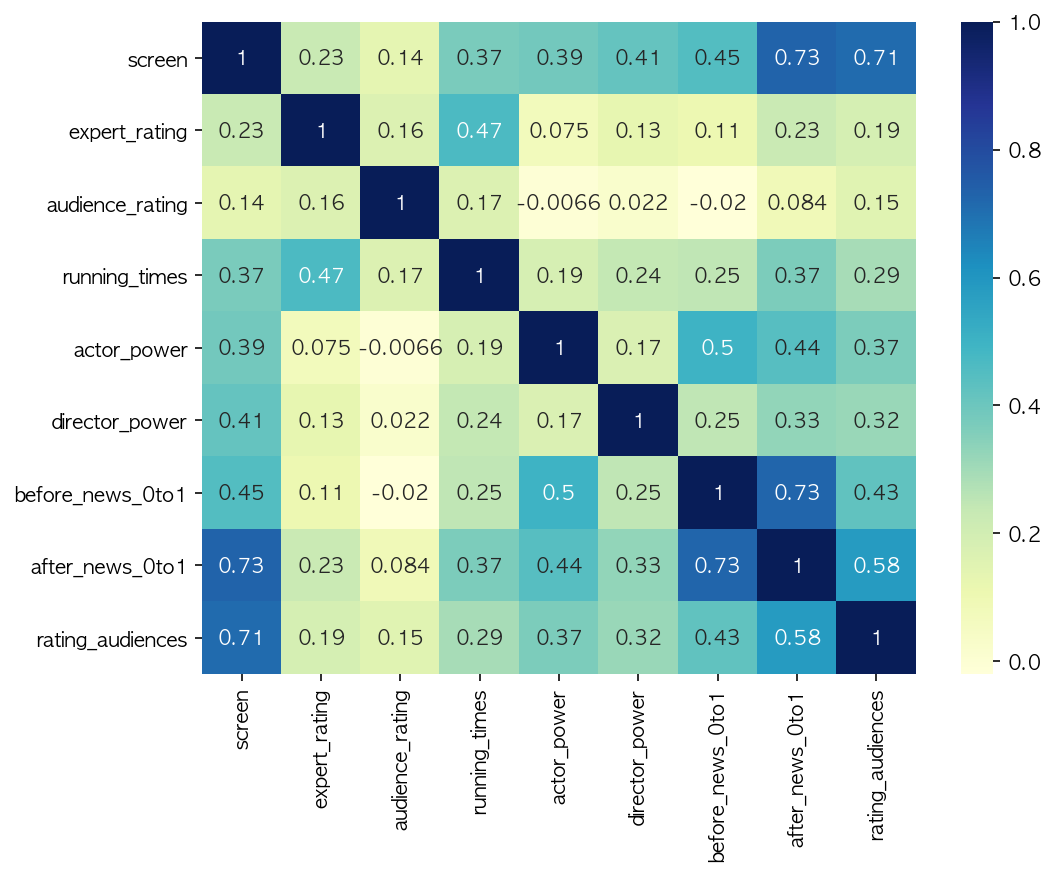

In [229]:
plt.figure(figsize=(8, 6))
sns.heatmap(df10_1.corr(), annot=True, cmap="YlGnBu")

plt.show()

In [230]:
# fig = plt.figure(figsize=(10, 46))
# sm.graphics.plot_partregress_grid(result10, fig=fig)
# fig.suptitle("")
# plt.show()

In [231]:
# 14개의 독립변수 사용

feature_names = ['screen**(4/7)', 'expert_rating',
                 'actor_power', 'director_power', 'np.log(before_news_0to1)', 'np.log(after_news_0to1)', 'rating_audiences**(3/7)', 'rating_audiences**2', 'holiday']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model10 = sm.OLS.from_formula(
    "log_aud ~" + "+".join(feature_names), data=df10)
result10 = model10.fit()
print(result10.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     113.4
Date:                Wed, 15 Apr 2020   Prob (F-statistic):          4.38e-259
Time:                        17:00:37   Log-Likelihood:                -643.18
No. Observations:                 735   AIC:                             1356.
Df Residuals:                     700   BIC:                             1517.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [232]:
# kfold 10

from sklearn.model_selection import KFold

kfold_dict_learn['10'] = []
kfold_dict['10'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df10)):
    df_train = df10.iloc[idx_train]
    df_test = df10.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'actor_power', 'director_power',
                                   'before_news_0to1', 'after_news_0to1', 'rating_audiences', 'holiday', 'dist_cat', 'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict_learn['10'].append(result.rsquared)
    kfold_dict['10'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['10'])/10)

학습 R2 = 0.84292205, 검증 R2 = 0.85747202
학습 R2 = 0.84722304, 검증 R2 = 0.82632838
학습 R2 = 0.84316901, 검증 R2 = 0.86731020
학습 R2 = 0.84199269, 검증 R2 = 0.86777598
학습 R2 = 0.85235720, 검증 R2 = 0.76834668
학습 R2 = 0.84847463, 검증 R2 = 0.80568731
학습 R2 = 0.85218493, 검증 R2 = 0.77253358
학습 R2 = 0.84947959, 검증 R2 = 0.80684406
학습 R2 = 0.84522093, 검증 R2 = 0.84512241
학습 R2 = 0.84948193, 검증 R2 = 0.80752614


In [233]:
# model10의 테스트 R

pred = result10.predict(X_test[['screen', 'expert_rating', 'actor_power', 'director_power',
                                'before_news_0to1', 'after_news_0to1', 'rating_audiences', 'holiday', 'dist_cat', 'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.8261355515072468

In [234]:
test_rsquare_arr.append(0.8261355515072468)

In [235]:
pred = result10.predict(X_test)
print('Mean_Squared_Error = ', mean_squared_error(
    pred, y_test['aud_nationwide']))
print('RMSE = ', mean_squared_error(pred, y_test['aud_nationwide'])**0.5)
RMSE_dict['10'] = mean_squared_error(pred, y_test['aud_nationwide'])**0.5

Mean_Squared_Error =  4822243370637.978
RMSE =  2195960.6942379405


In [236]:
result_rsquare['result10_rsquared'] = result10.rsquared
result_adj_rsquare['result10_adj_rsquared'] = result10.rsquared_adj

# model11
- ANOVA 테스트로 범주형 변수 선별하고 성능 변화 확인하기
    - 범주형 컬럼 중 anova f-test의 p-value가 가장 높은 세개 먼저 제거
        - nation, genre, rate

In [237]:
df11 = df10.copy()

In [238]:
# anova 테스트

sm.stats.anova_lm(result10, typ=2)

,sum_sq,df,F,PR(>F)
dist_cat,2.016073,2.0,2.848940,5.857732e-02
nation,1.658750,5.0,0.937601,4.558591e-01
genre,6.779130,13.0,1.473797,1.215687e-01
rate,1.874039,3.0,1.765487,1.523866e-01
C(sequel),1.596808,1.0,4.512942,3.398921e-02
C(original),0.915481,1.0,2.587357,1.081708e-01
scale(screen ** (4 / 7)),50.040384,1.0,141.425501,7.803679e-30
scale(expert_rating),0.420033,1.0,1.187109,2.762884e-01
scale(actor_power),0.259265,1.0,0.732741,3.922891e-01
scale(director_power),0.722400,1.0,2.041666,1.534880e-01


In [239]:
df11 = df10.drop(columns=['nation', 'genre', 'rate', 'dist_cat'])

In [240]:
# 16개의 독립변수 사용

feature_names = ['screen**(4/7)', 'expert_rating',
                 'actor_power', 'director_power', 'np.log(before_news_0to1)', 'np.log(after_news_0to1)', 'rating_audiences**(3/7)', 'rating_audiences**2', 'holiday']
feature_names = ["scale({})".format(name)
                 for name in feature_names] + ['C(sequel)', 'C(original)']
model11 = sm.OLS.from_formula(
    "log_aud ~" + "+".join(feature_names), data=df11)
result11 = model11.fit()
print(result11.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     341.6
Date:                Wed, 15 Apr 2020   Prob (F-statistic):          1.17e-277
Time:                        17:00:39   Log-Likelihood:                -661.23
No. Observations:                 735   AIC:                             1346.
Df Residuals:                     723   BIC:                             1402.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [241]:
# kfold 11

from sklearn.model_selection import KFold

kfold_dict_learn['11'] = []
kfold_dict['11'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df11)):
    df_train = df11.iloc[idx_train]
    df_test = df11.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'actor_power', 'director_power',
                                   'before_news_0to1', 'after_news_0to1', 'rating_audiences', 'holiday', 'sequel', 'original']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict_learn['11'].append(result.rsquared)
    kfold_dict['11'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['11'])/10)

학습 R2 = 0.83580195, 검증 R2 = 0.84993821
학습 R2 = 0.83870707, 검증 R2 = 0.83290446
학습 R2 = 0.83595875, 검증 R2 = 0.85825542
학습 R2 = 0.83455386, 검증 R2 = 0.86068654
학습 R2 = 0.84388763, 검증 R2 = 0.77747769
학습 R2 = 0.83803858, 검증 R2 = 0.83512696
학습 R2 = 0.84309853, 검증 R2 = 0.78946861
학습 R2 = 0.84085418, 검증 R2 = 0.81513469
학습 R2 = 0.83729072, 검증 R2 = 0.84309380
학습 R2 = 0.84139065, 검증 R2 = 0.80922389


In [242]:
# model11의 테스트 R

pred = result11.predict(X_test[['screen', 'expert_rating', 'actor_power', 'director_power',
                                'before_news_0to1', 'after_news_0to1', 'rating_audiences', 'holiday', 'sequel', 'original']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.8249483856296358

In [243]:
test_rsquare_arr.append(0.8249483856296358)

In [244]:
pred = result11.predict(X_test)
print('Mean_Squared_Error = ', mean_squared_error(
    pred, y_test['aud_nationwide']))
print('RMSE = ', mean_squared_error(pred, y_test['aud_nationwide'])**0.5)
RMSE_dict['11'] = mean_squared_error(pred, y_test['aud_nationwide'])**0.5

Mean_Squared_Error =  4822243363836.751
RMSE =  2195960.692689364


In [245]:
result_rsquare['result11_rsquared'] = result11.rsquared
result_adj_rsquare['result11_adj_rsquared'] = result11.rsquared_adj

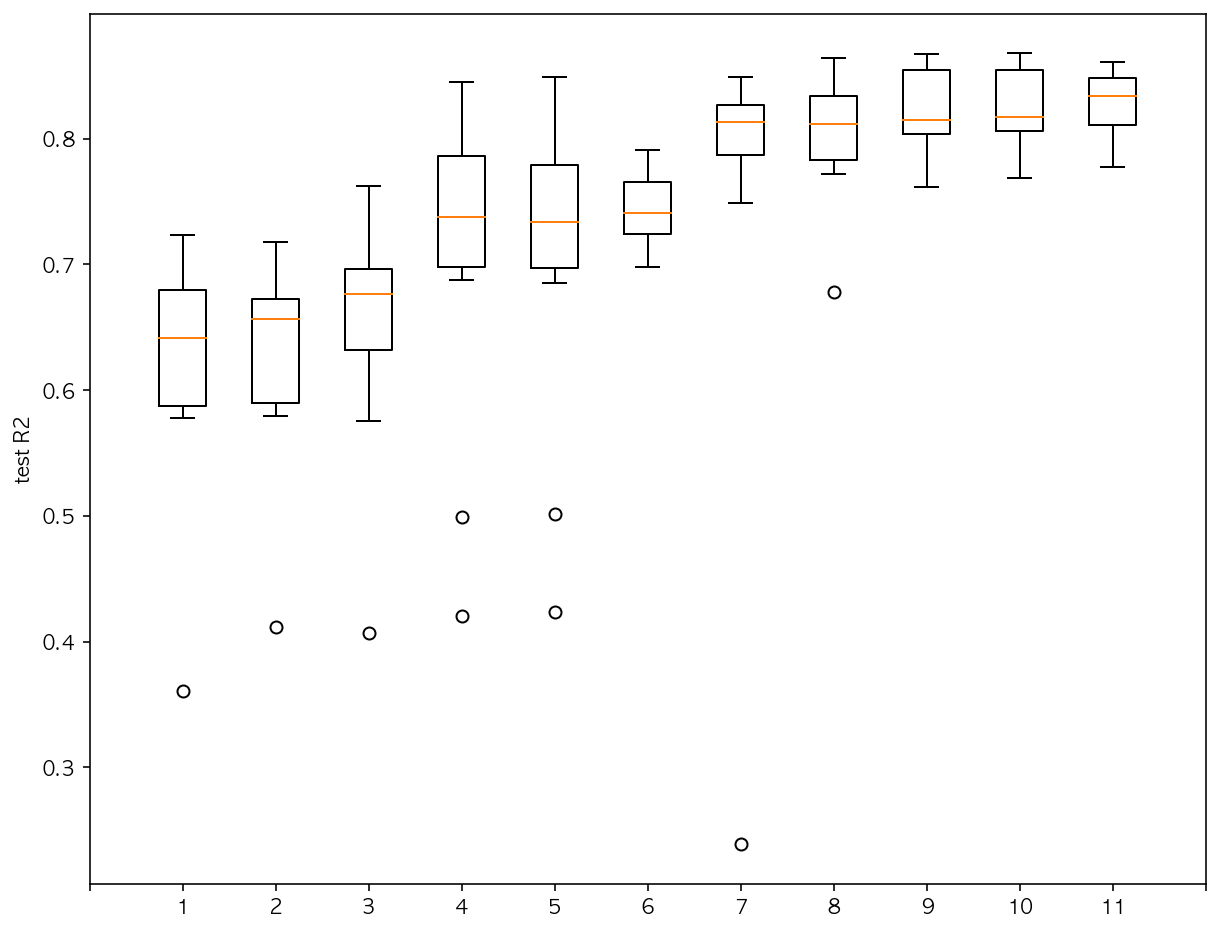

In [246]:
for i in range(1, len(kfold_dict) + 1):
    kfold_df[str(i)] = kfold_dict[str(i)]

plt.figure(figsize=(10, 8))
plt.boxplot((kfold_df['1'], kfold_df['2'], kfold_df['3'], kfold_df['4'],
             kfold_df['5'], kfold_df['6'], kfold_df['7'], kfold_df['8'], kfold_df['9'], kfold_df['10'], kfold_df['11']))
plt.ylabel("test R2")
plt.xticks(np.arange(13), ('', '1', '2', '3',
                           '4', '5', '6', '7', '8', '9', '10', '11'))

plt.show()

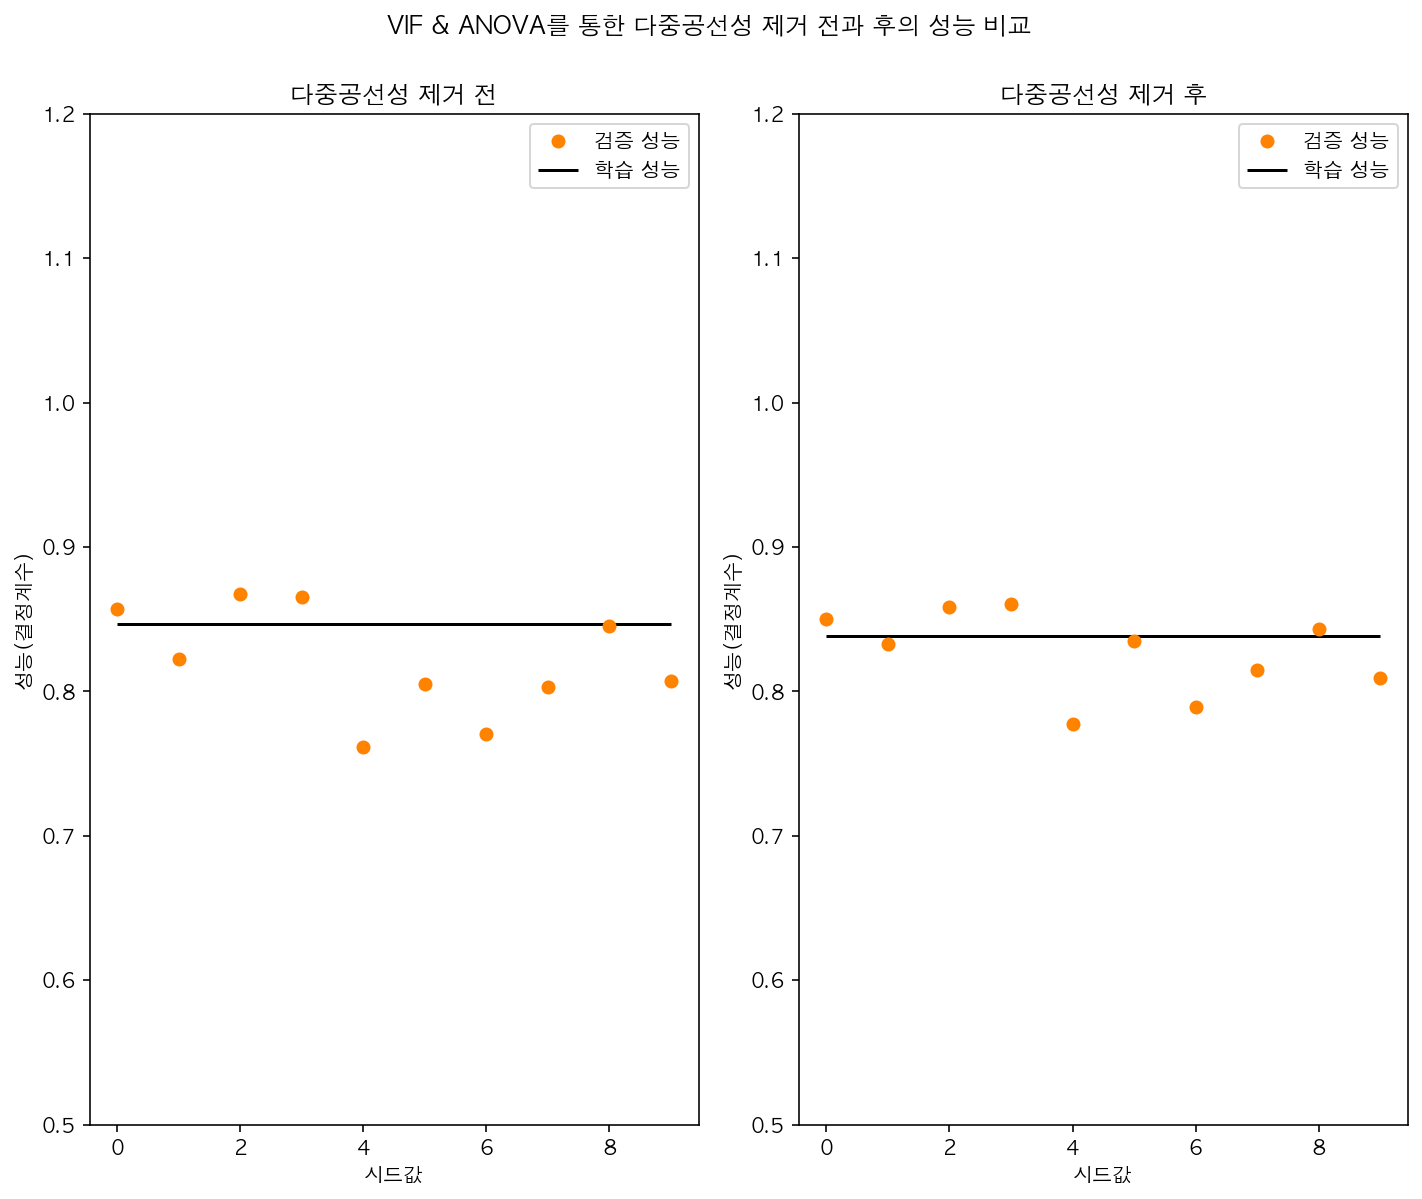

In [247]:
plt.figure(figsize=(10, 8))
plt.subplot(121)
plt.plot(kfold_dict['9'], 'ro', label="검증 성능", color="#FF8200")
plt.hlines(result9.rsquared, 0, 9, label="학습 성능")
plt.legend()
plt.xlabel("시드값")
plt.ylabel("성능(결정계수)")
plt.title("다중공선성 제거 전")
plt.ylim(0.5, 1.2)

plt.subplot(122)
plt.plot(kfold_dict['11'], 'ro', label="검증 성능", color="#FF8200")
plt.hlines(result11.rsquared, 0, 9, label="학습 성능")
plt.legend()
plt.xlabel("시드값")
plt.ylabel("성능(결정계수)")
plt.title("다중공선성 제거 후")
plt.ylim(0.5, 1.2)

plt.suptitle("VIF & ANOVA를 통한 다중공선성 제거 전과 후의 성능 비교", y=1.04)
plt.tight_layout()
plt.show()

In [249]:
RMSE_dict

{'1': 1216819.0477631732,
 '2': 1188747.638878766,
 '3': 1156389.3520695297,
 '4': 1053773.5748202384,
 '5': 1063902.421634523,
 '6': 2195960.731106855,
 '7': 2195960.6829151516,
 '8': 2195960.6820834344,
 '9': 2195960.6934031,
 '10': 2195960.6942379405,
 '11': 2195960.692689364}

In [250]:
value_arr = []
for key, value in RMSE_dict.items():
    value_arr.append(value)

In [251]:
RMSE_df = pd.DataFrame(columns=['RMSE'])

In [252]:
RMSE_df['RMSE'] = value_arr

In [254]:
RMSE_df = RMSE_df.reset_index()

In [255]:
RMSE_df_1to5 = RMSE_df[:5]

In [256]:
RMSE_df = RMSE_df.rename(columns={'index': 'model_num'})

In [257]:
RMSE_df['model_num'] = ['model1', 'model2', 'model3', 'model4', 'model5',
                        'model6', 'model7', 'model8', 'model9', 'model10', 'model11']

In [258]:
RMSE_df

,model_num,RMSE
0,model1,1.216819e+06
1,model2,1.188748e+06
2,model3,1.156389e+06
3,model4,1.053774e+06
4,model5,1.063902e+06
5,model6,2.195961e+06
6,model7,2.195961e+06
7,model8,2.195961e+06
8,model9,2.195961e+06
9,model10,2.195961e+06


In [259]:
RMSE_df_1to5

,index,RMSE
0,0,1.216819e+06
1,1,1.188748e+06
2,2,1.156389e+06
3,3,1.053774e+06
4,4,1.063902e+06


In [260]:
result_adj_rsquare

{'result1_adj_rsquared': 0.6380551630255376,
 'result2_adj_rsquared': 0.6513426529836526,
 'result3_adj_rsquared': 0.6751045430267892,
 'result4_adj_rsquared': 0.7305625388922838,
 'result5_adj_rsquared': 0.7313340167990148,
 'result6_adj_rsquared': 0.773489077763822,
 'result7_adj_rsquared': 0.8263705827714308,
 'result8_adj_rsquared': 0.8305335769100374,
 'result9_adj_rsquared': 0.8385539124277568,
 'result10_adj_rsquared': 0.8389298015101325,
 'result11_adj_rsquared': 0.8362003159843964}

In [271]:
value_arr = []
for key, value in result_rsquare.items():
    value_arr.append(value)

In [270]:
# RMSE_df

In [ ]:
# kfold_dict_learn = {}
# kfold_dict = {}
# kfold_dict_avr = []
# RMSE_dict = {}
# result_rsquare = {}
# result_adj_rsquare = {}
# kfold_df = pd.DataFrame()

In [278]:
# result_df['rsquare'] = value_arr

In [276]:
# result_df['test_rsquare'] = test_rsquare_arr

In [279]:
result_df.to_csv("result_df_02")

In [1620]:
# result_df.to_csv("result_df.csv")

In [1581]:
# kfold_dict_learn
# kfold_dict
# kfold_dict_avr

In [1619]:
result_df_1to5 = result_df[:5]

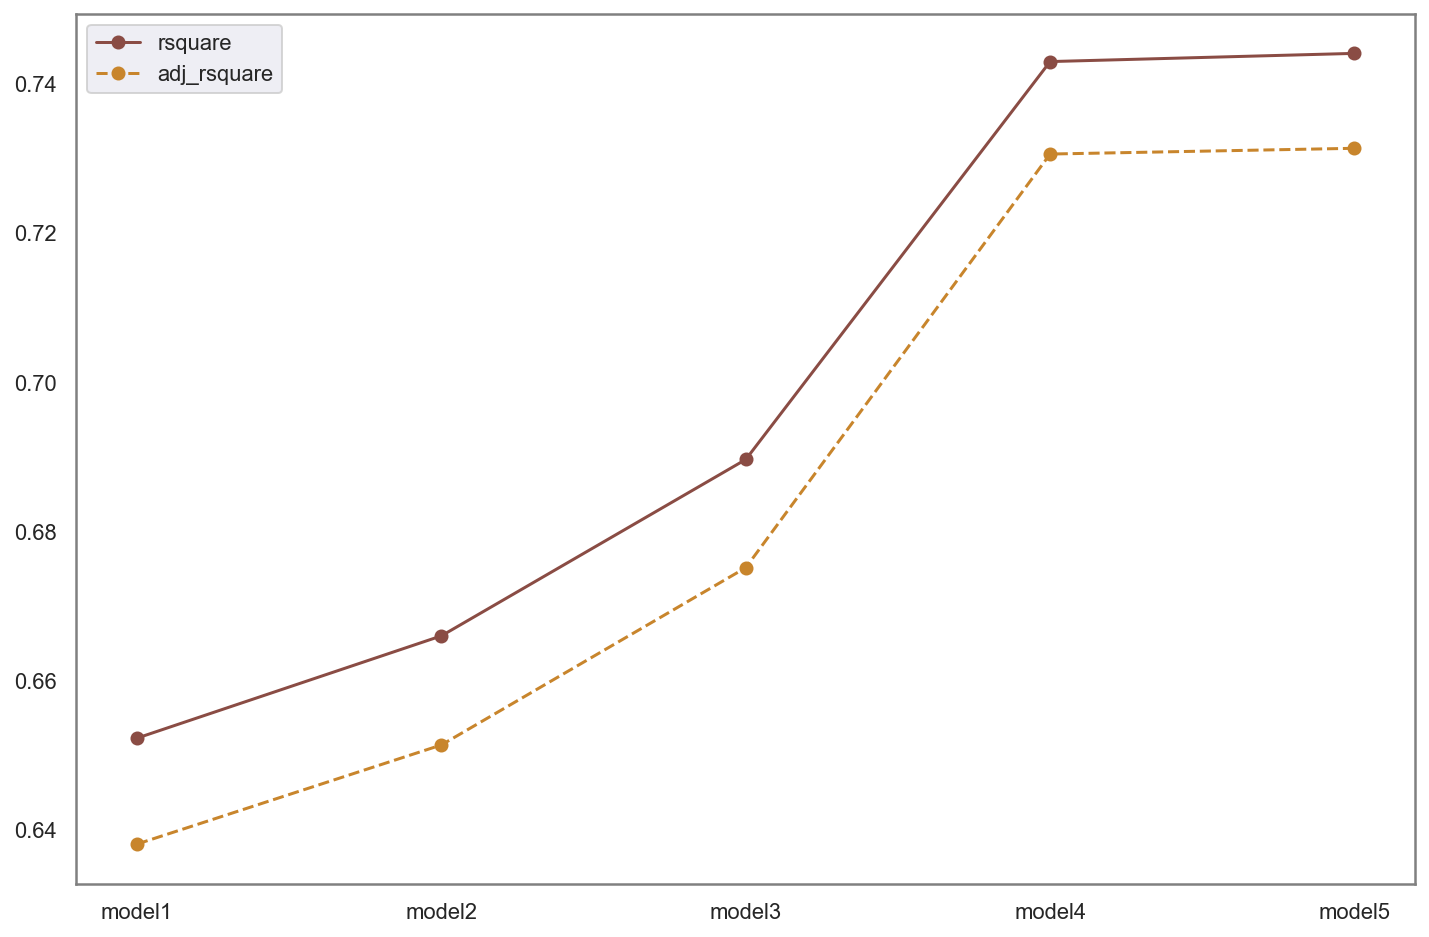

In [1952]:
# fig, ax = plt.subplots()
# sns.set(rc={'figure.figsize':(10, 6)})
# plt.axis('on')
# plt.grid(b=None)
# plt.rcParams['axes.facecolor'] = 'white'
plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.set_facecolor("white")
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
# plt.grid(color='black', linestyle='-', linewidth=0.5)
ax.plot(result_df_1to5['model_num'], result_df_1to5['rsquare'], "go-" ,color='#8A4C44', label='rsquare')
ax.plot(result_df_1to5['model_num'], result_df_1to5['adj_rsquare'], "go--",color='#C8852C', label='adj_rsquare')
ax.legend()
plt.show()


In [1914]:
# fig, ax = plt.subplots()

# sns.set(rc={'figure.figsize':(10, 6)})
# sns.pointplot(x='model_num', y='rsquare', data=result_df_1to5, ax=ax, color='#8A4C44', labels='rsquare', markers=['o'])
# sns.pointplot(x='model_num', y='adj_rsquare', data=result_df_1to5, ax=ax, color='#C8852C', labels='adj_rsquare', markers=['o'], linestyles=['--'])
# fig.legend(labels=['rsquare', 'adj_rsquare'])
# labels = ax.get_legend_handles_labels()[1]

# fig.show()
# # ax.set_xticklabels(labels, rotation=-30)

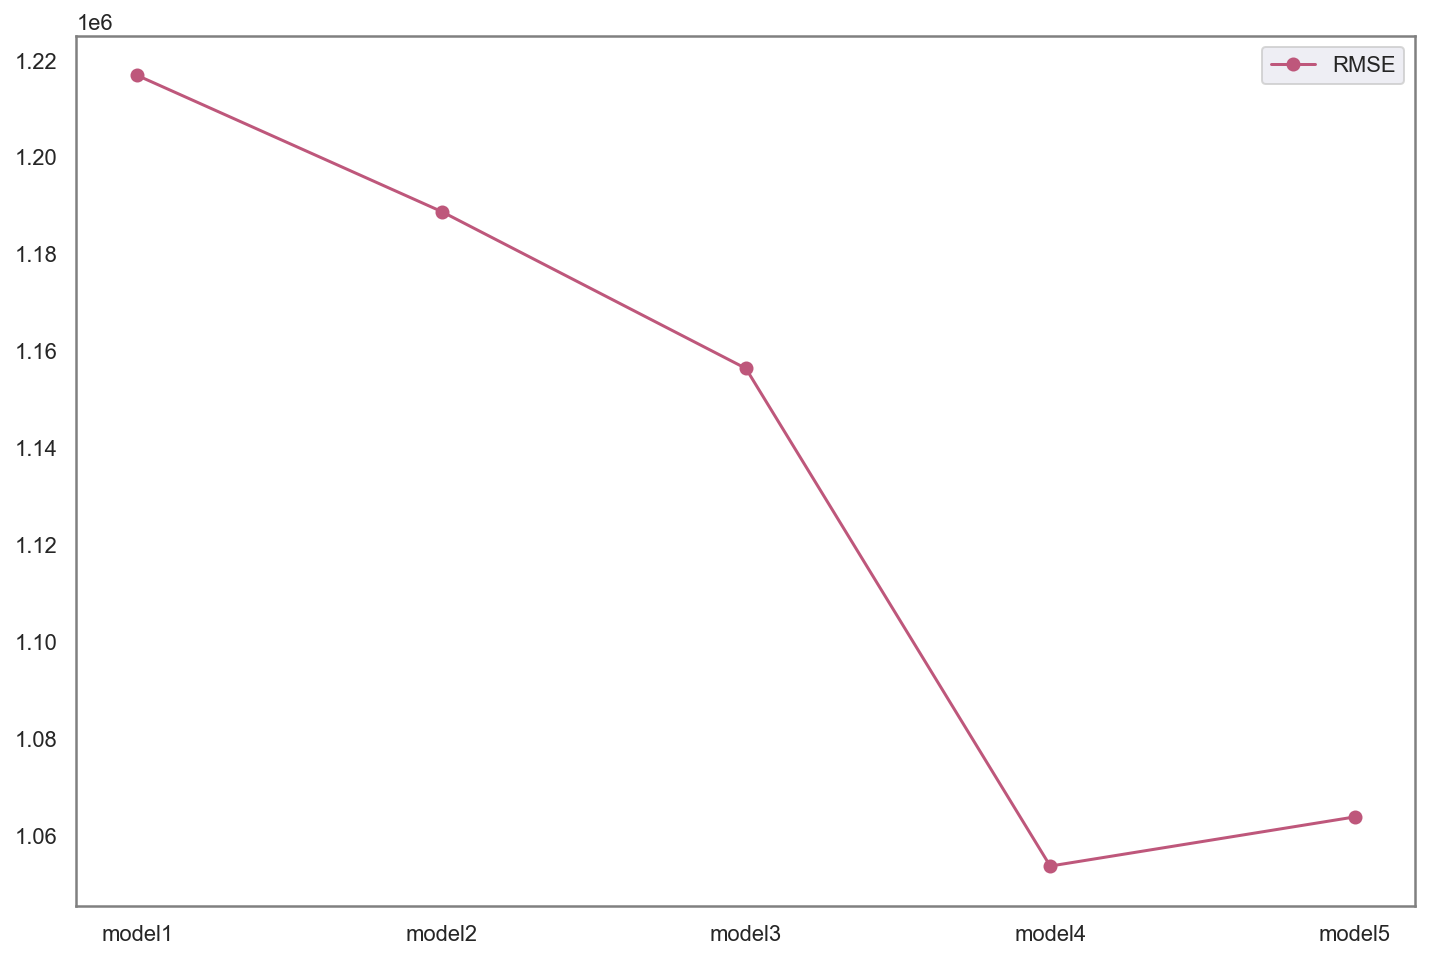

In [1957]:
plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.set_facecolor("white")
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
# plt.grid(color='black', linestyle='-', linewidth=0.5)
ax.plot(RMSE_df_1to5['model_num'], RMSE_df_1to5['RMSE'], "go-" ,color='#BE577B', label='RMSE')
plt.legend()
plt.show()

In [1821]:
result_df_5to12 = result_df[4:]

In [1822]:
result_df_5to12

,model_num,RMSE,rsquare,adj_rsquare,test_rsquare
4,model5,1.063902e+06,0.744058,0.731334,0.699099
5,model6,2.195961e+06,0.784217,0.773489,0.743955
6,model7,2.195961e+06,0.832155,0.823560,0.811227
7,model8,2.195961e+06,0.837119,0.828766,0.819243
8,model9,2.195961e+06,0.844734,0.836726,0.823986
9,model10,2.195961e+06,0.846472,0.838554,0.827236
10,model11,2.195961e+06,0.846391,0.838930,0.826136
11,model12,2.195961e+06,0.838655,0.836200,0.824948


In [303]:
# plt.figure(figsize=(12, 8))
# ax = plt.axes()
# ax.set_facecolor("white")
# ax.spines['bottom'].set_color('0.5')
# ax.spines['top'].set_color('0.5')
# ax.spines['right'].set_color('0.5')
# ax.spines['left'].set_color('0.5')
# # plt.grid(color='black', linestyle='-', linewidth=0.5)
# ax.plot(result_df_5to12['model_num'], result_df_5to12['test_rsquare'], "go-" ,color='#E16350', label='test_rsquare')
# plt.legend()
# plt.show()


In [1841]:
# for i in range(1, len(kfold_dict) + 1):
#     kfold_df[str(i)] = kfold_dict[str(i)]

# plt.figure(figsize=(10, 8))
# plt.boxplot((kfold_df['1'], kfold_df['2'], kfold_df['3'], kfold_df['4'],
#              kfold_df['5']))
# plt.ylabel("test R2")
# plt.xticks(np.arange(7), ('', '1', '2', '3',
#                            '4', '5'))

# plt.show()

In [1853]:
# for i in range(1, len(kfold_dict) + 1):
#     kfold_df[str(i)] = kfold_dict[str(i)]

# plt.figure(figsize=(10, 8))
# plt.boxplot((kfold_df['1'], kfold_df['2'], kfold_df['3'], kfold_df['4'],
#              kfold_df['5'], kfold_df['6'], kfold_df['7'], kfold_df['8'], kfold_df['9'], kfold_df['10'], kfold_df['11'],  kfold_df['12']))
# plt.ylabel("test R2")
# plt.xticks(np.arange(14), ('', '1', '2', '3',
#                            '4', '5', '6', '7', '8', '9', '10', '11', '12'))

# plt.show()

In [1854]:
# for i in range(1, len(kfold_dict) + 1):
#     kfold_df[str(i)] = kfold_dict[str(i)]

# plt.figure(figsize=(10, 8))
# plt.boxplot((kfold_df['5'], kfold_df['6'], kfold_df['7'], kfold_df['8'], kfold_df['9'], kfold_df['10'], kfold_df['11'],  kfold_df['12']))
# plt.ylabel("test R2")
# plt.xticks(np.arange(9), ('',  '5', '6', '7', '8', '9', '10', '11', '12'))

# plt.show()

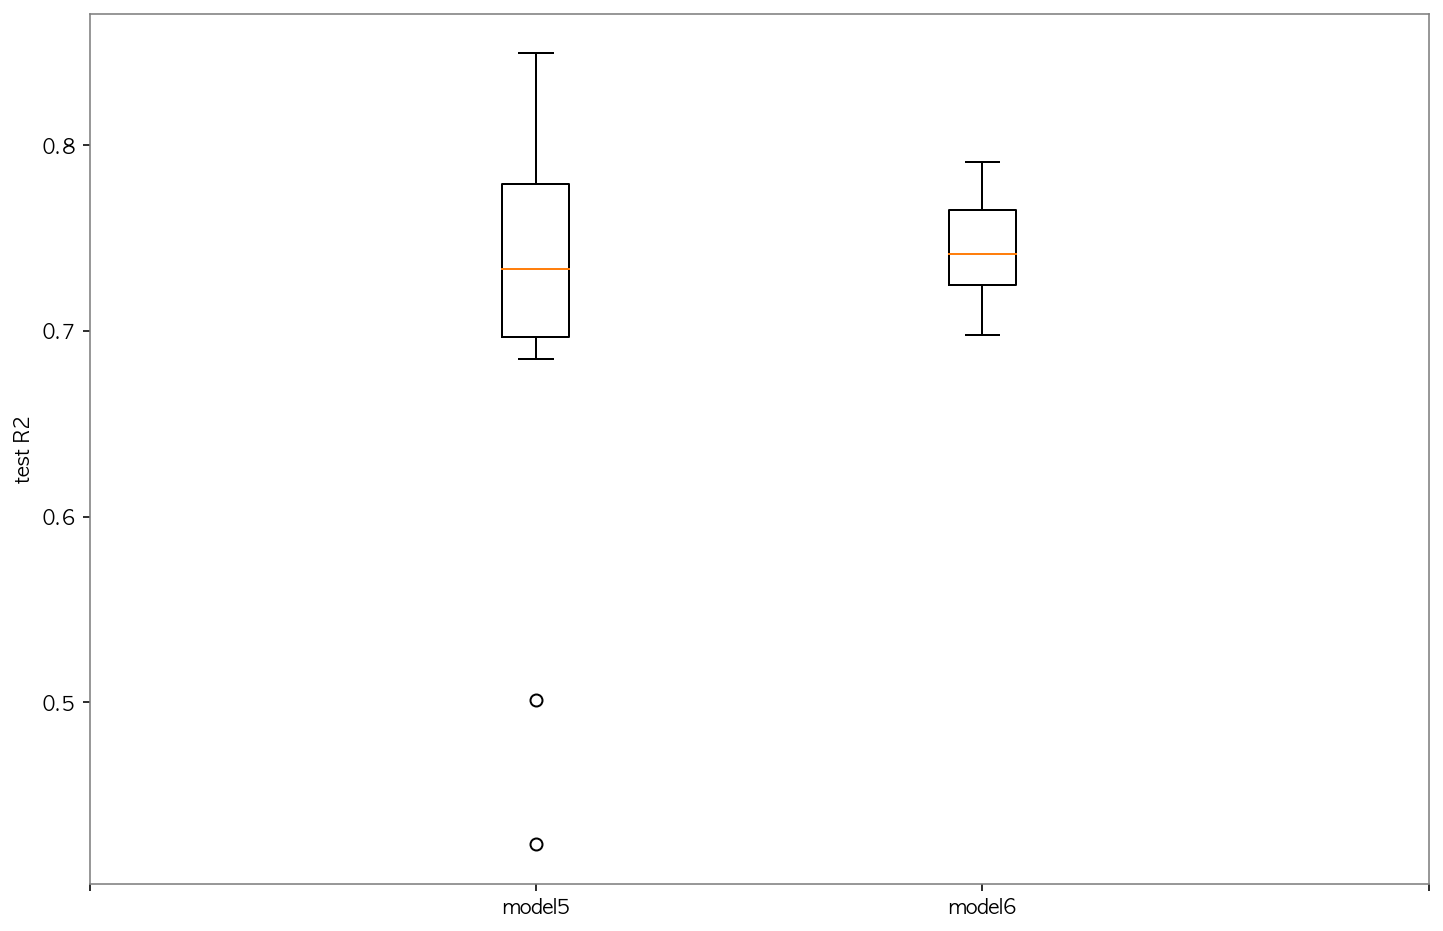

In [266]:
for i in range(1, len(kfold_dict) + 1):
    kfold_df[str(i)] = kfold_dict[str(i)]

plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.set_facecolor("white")
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
# plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.boxplot((kfold_df['5'], kfold_df['6']))
plt.ylabel("test R2")
plt.xticks(np.arange(4), ('', 'model5', 'model6'))

plt.show()

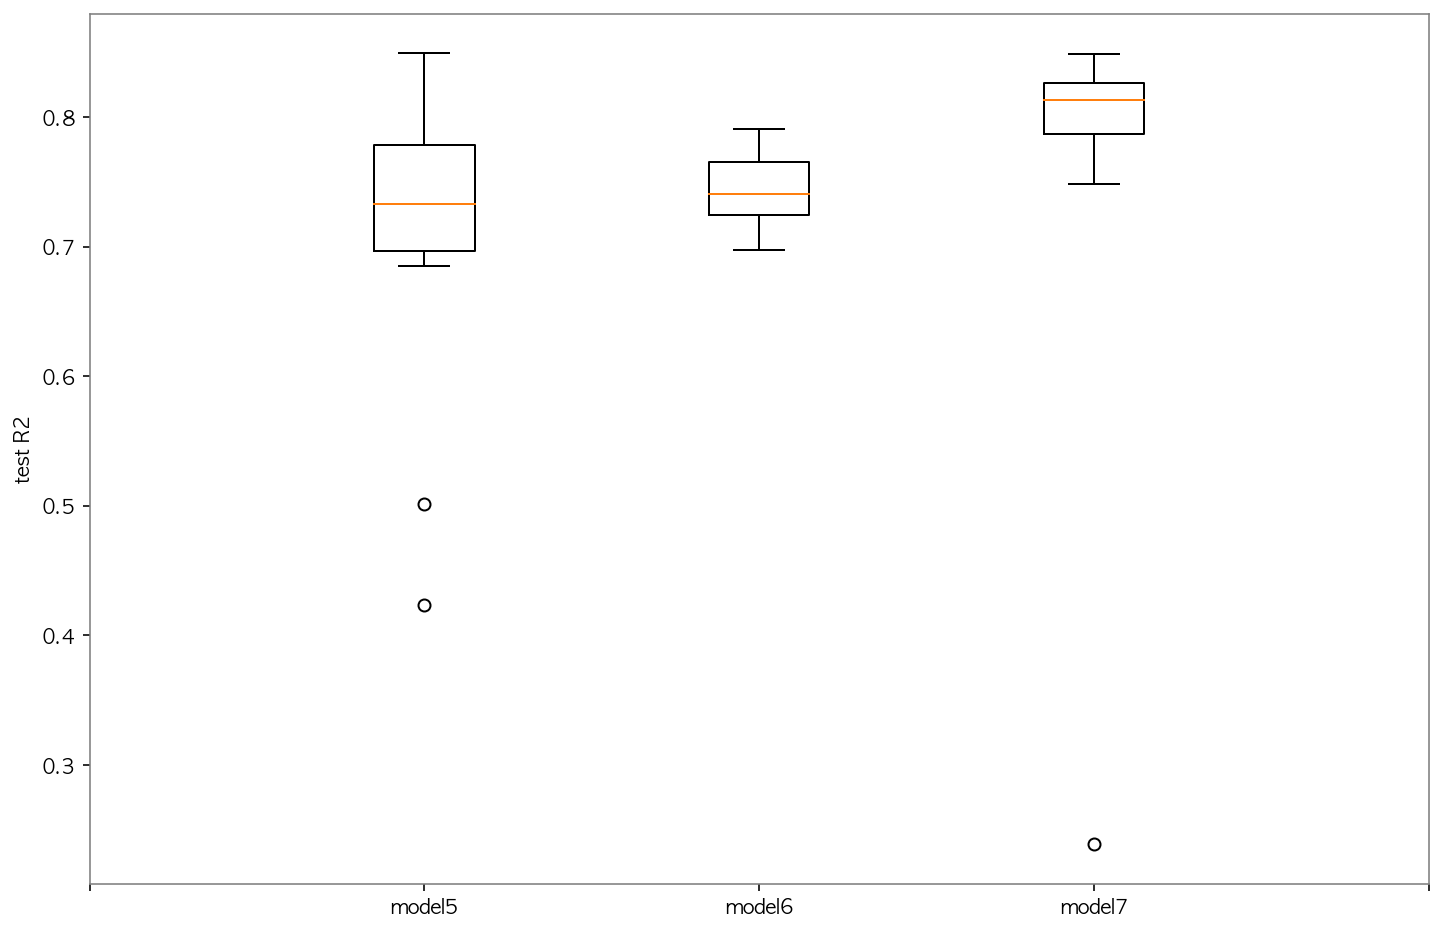

In [280]:
for i in range(1, len(kfold_dict) + 1):
    kfold_df[str(i)] = kfold_dict[str(i)]

plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.set_facecolor("white")
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
# plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.boxplot((kfold_df['5'], kfold_df['6'], kfold_df['7']))
plt.ylabel("test R2")
plt.xticks(np.arange(5), ('', 'model5', 'model6', 'model7'))

plt.show()

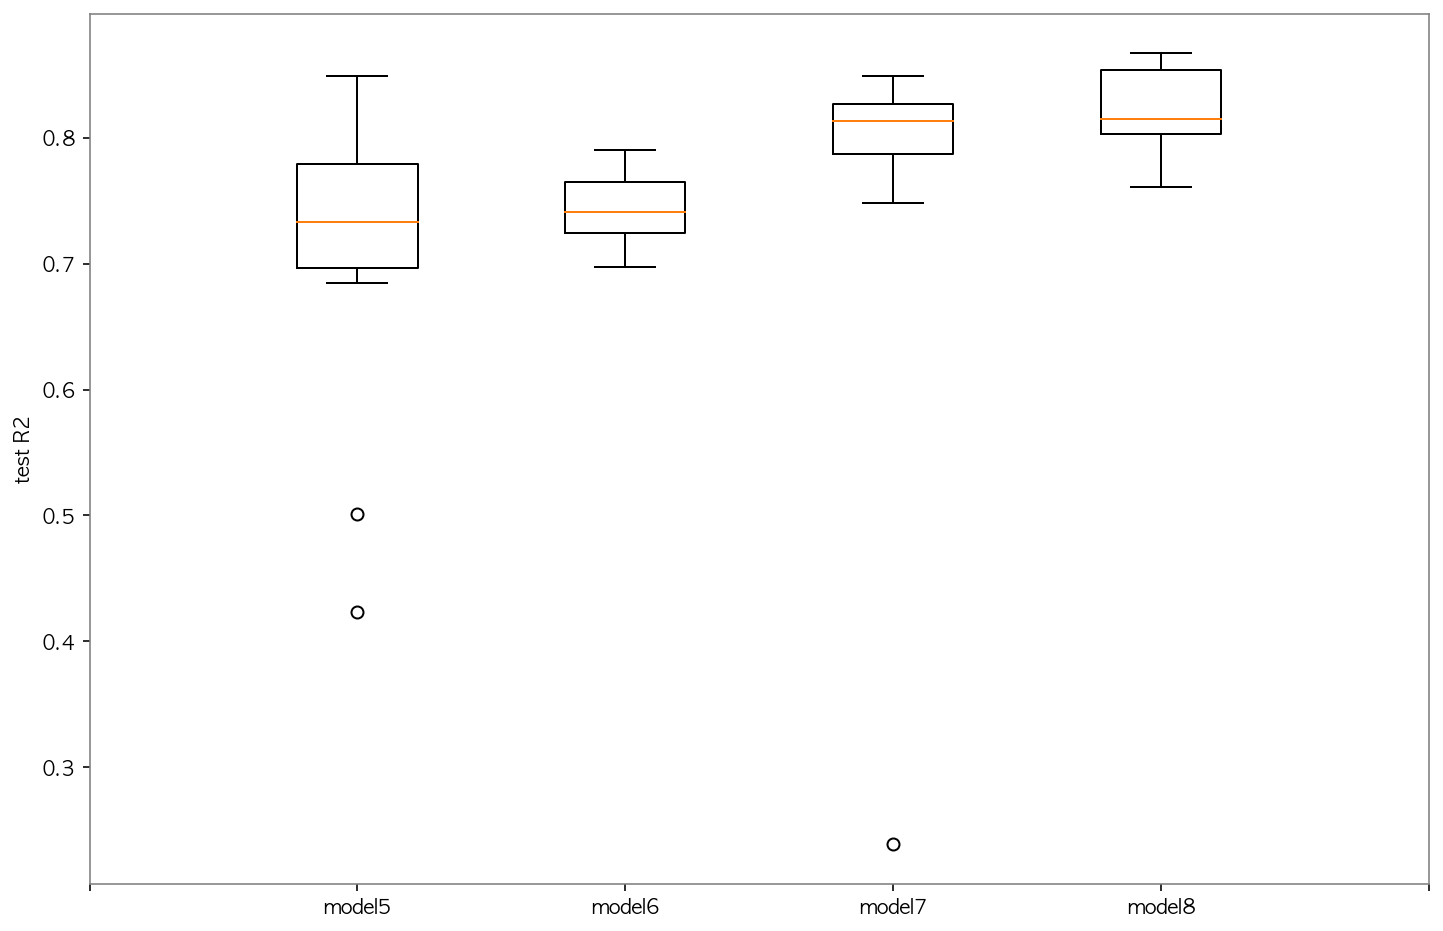

In [281]:
# 아웃라이어 제거한 모델 2개를 하나(model8로 표현)

for i in range(1, len(kfold_dict) + 1):
    kfold_df[str(i)] = kfold_dict[str(i)]

plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.set_facecolor("white")
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
# plt.grid(color='black', linestyle='-', linewidth=0.3)
plt.boxplot((kfold_df['5'], kfold_df['6'], kfold_df['7'], kfold_df['9']))
plt.ylabel("test R2")
plt.xticks(np.arange(6), ('', 'model5', 'model6', 'model7', 'model8',))

plt.show()

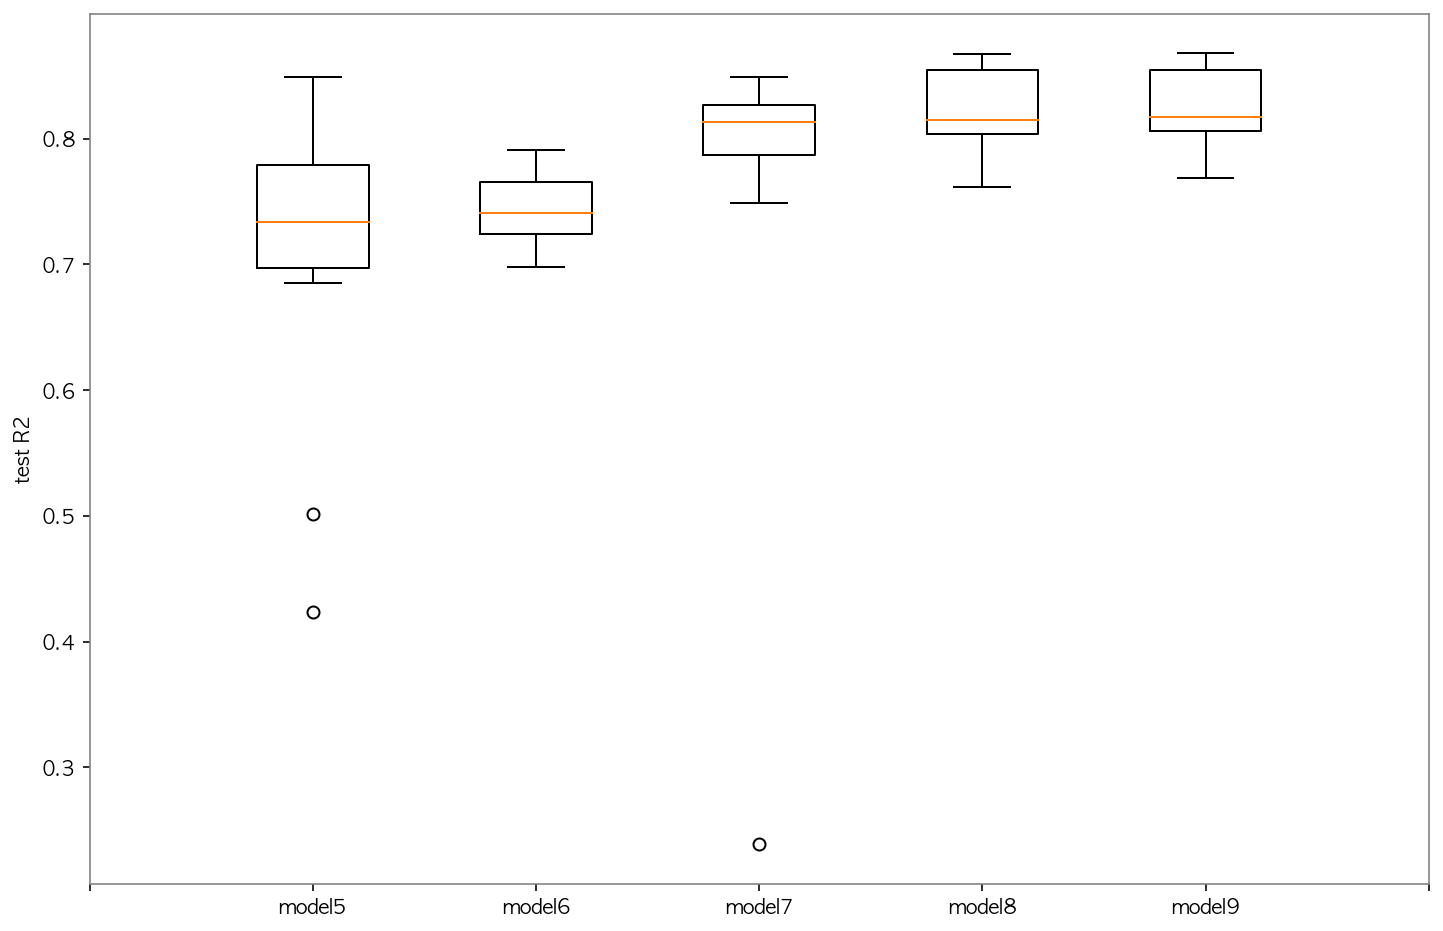

In [283]:
# VIF로 두개 컬럼 제거 

for i in range(1, len(kfold_dict) + 1):
    kfold_df[str(i)] = kfold_dict[str(i)]

plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.set_facecolor("white")
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
# plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.boxplot((kfold_df['5'], kfold_df['6'], kfold_df['7'], kfold_df['9'], kfold_df['10']))
plt.ylabel("test R2")
plt.xticks(np.arange(7), ('', 'model5', 'model6', 'model7', 'model8', 'model9'))

plt.show()

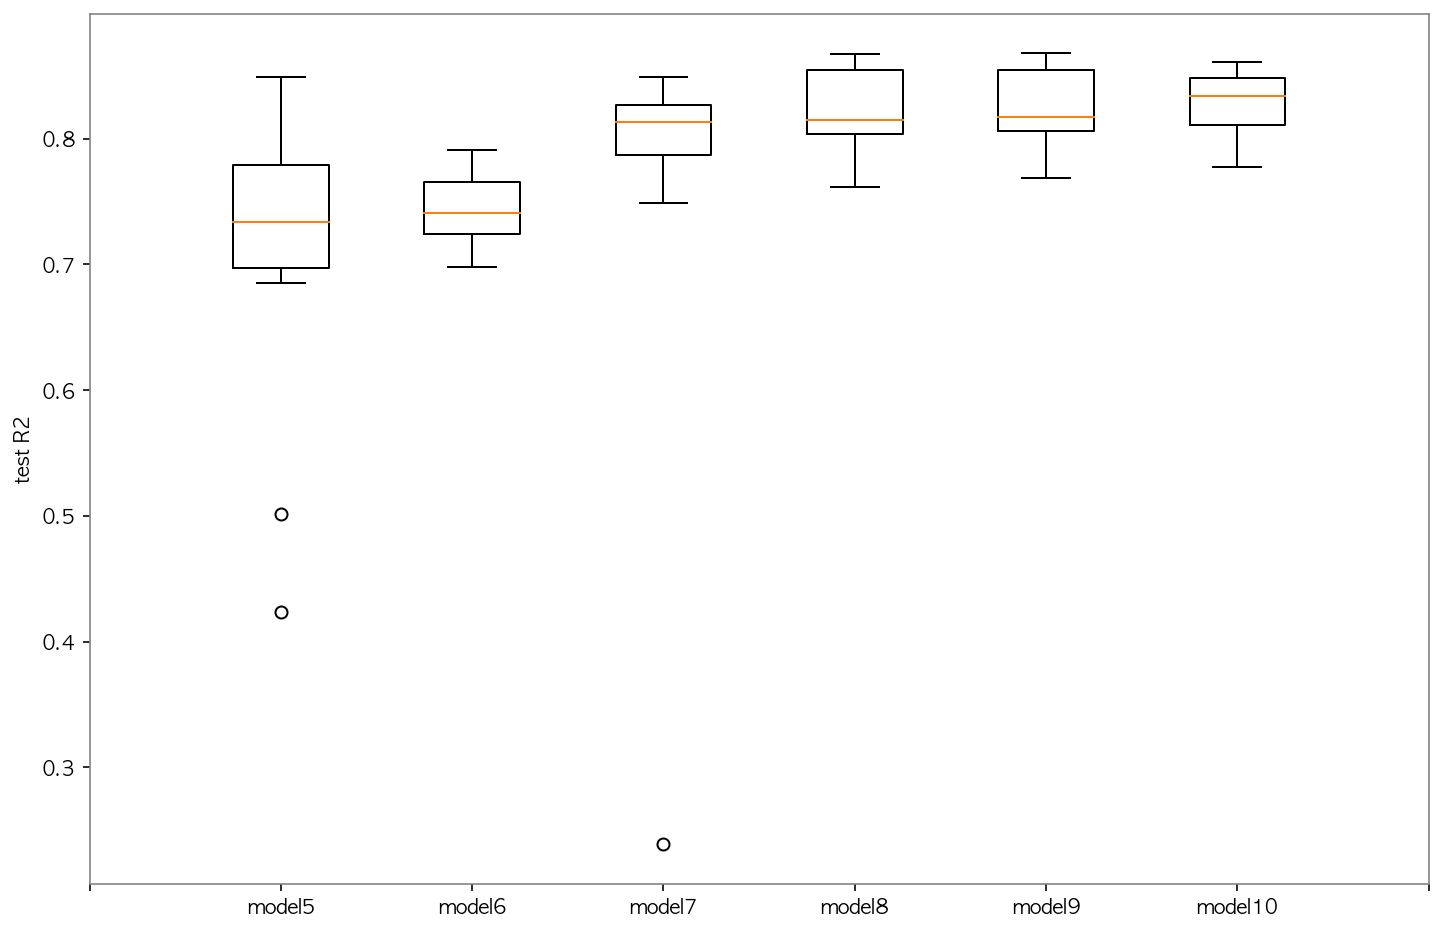

In [284]:
# Anova로 세개 컬럼 제거 

for i in range(1, len(kfold_dict) + 1):
    kfold_df[str(i)] = kfold_dict[str(i)]

plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.set_facecolor("white")
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
# plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.boxplot((kfold_df['5'], kfold_df['6'], kfold_df['7'], kfold_df['9'], kfold_df['10'], kfold_df['11']))
plt.ylabel("test R2")
plt.xticks(np.arange(8), ('', 'model5', 'model6', 'model7', 'model8', 'model9', 'model10'))

plt.show()

In [298]:
test_df = result_df[4:]

In [299]:
test_df = pd.concat([test_df[:3], test_df[4:]], axis=0)

In [301]:
test_df['model_num'] = ['model5', 'model6', 'model7', 'model8', 'model9', 'model10']

In [302]:
test_df

,model_num,RMSE,adj_rsquare,rsquare,test_rsquare
4,model5,1.063902e+06,0.731334,0.744058,0.699099
5,model6,2.195961e+06,0.773489,0.784217,0.743955
6,model7,2.195961e+06,0.826371,0.834829,0.815415
8,model8,2.195961e+06,0.838554,0.846472,0.827236
9,model9,2.195961e+06,0.838930,0.846391,0.826136
10,model10,2.195961e+06,0.836200,0.838655,0.824948


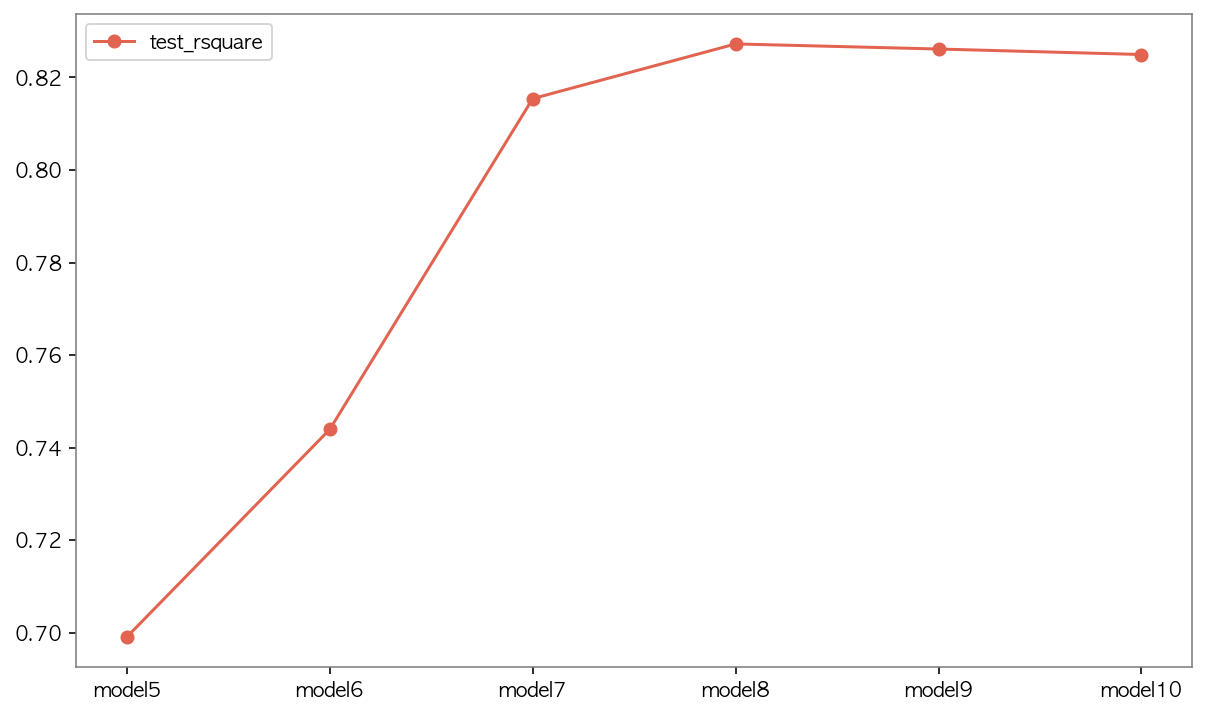

In [304]:
# model5부터의 test_R2

plt.figure(figsize=(10, 6))
ax = plt.axes()
ax.set_facecolor("white")
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
# plt.grid(color='black', linestyle='-', linewidth=0.5)
ax.plot(test_df['model_num'], test_df['test_rsquare'], "go-" ,color='#E16350', label='test_rsquare')
plt.legend()
plt.show()

- 종속변수 로그변환
    - QQ플롯의 변화, 정속변수의 값 변화
- 스크린에 root씌우고 한 도메인적인 근거 찾기-> 표, 그래프 
- 뉴스 등에 로그 처리한 이유 -> 스캐터플롯 등의 그래프
- 변형을 거친 수치 독립변수들 모두 이런 과정들 표나 그래프로 나타내기
- kfold 박스플롯을 result별로 순서대로 따로 나타내기 
- 아웃라이어 

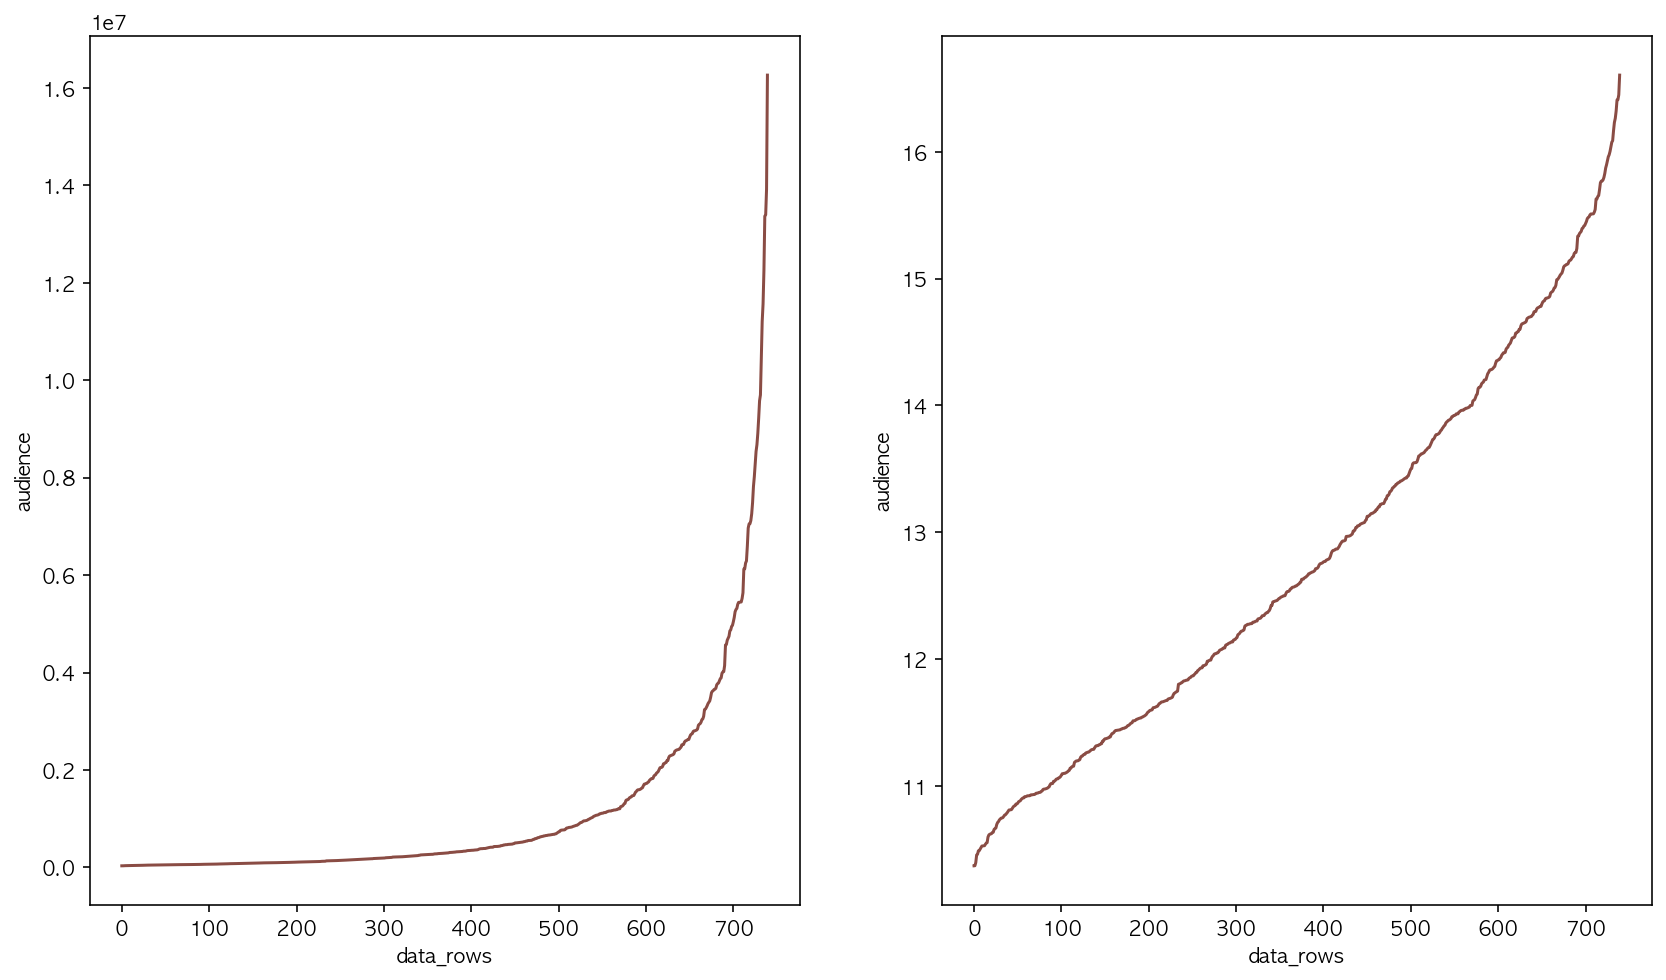

In [288]:
plt.figure(figsize=(14, 8))
plt.subplot(121)
# plt.title("로그변환 전")
plt.plot(df6['aud_nationwide'].sort_values().reset_index(drop=True), color="#8A4C44")
plt.xlabel('data_rows')
plt.ylabel('audience')
plt.subplot(122)
# plt.title("로그변환 후")
plt.plot(np.log(df6['aud_nationwide'].sort_values().reset_index(drop=True)), color="#8A4C44")
plt.xlabel('data_rows')
plt.ylabel('audience')
plt.show()

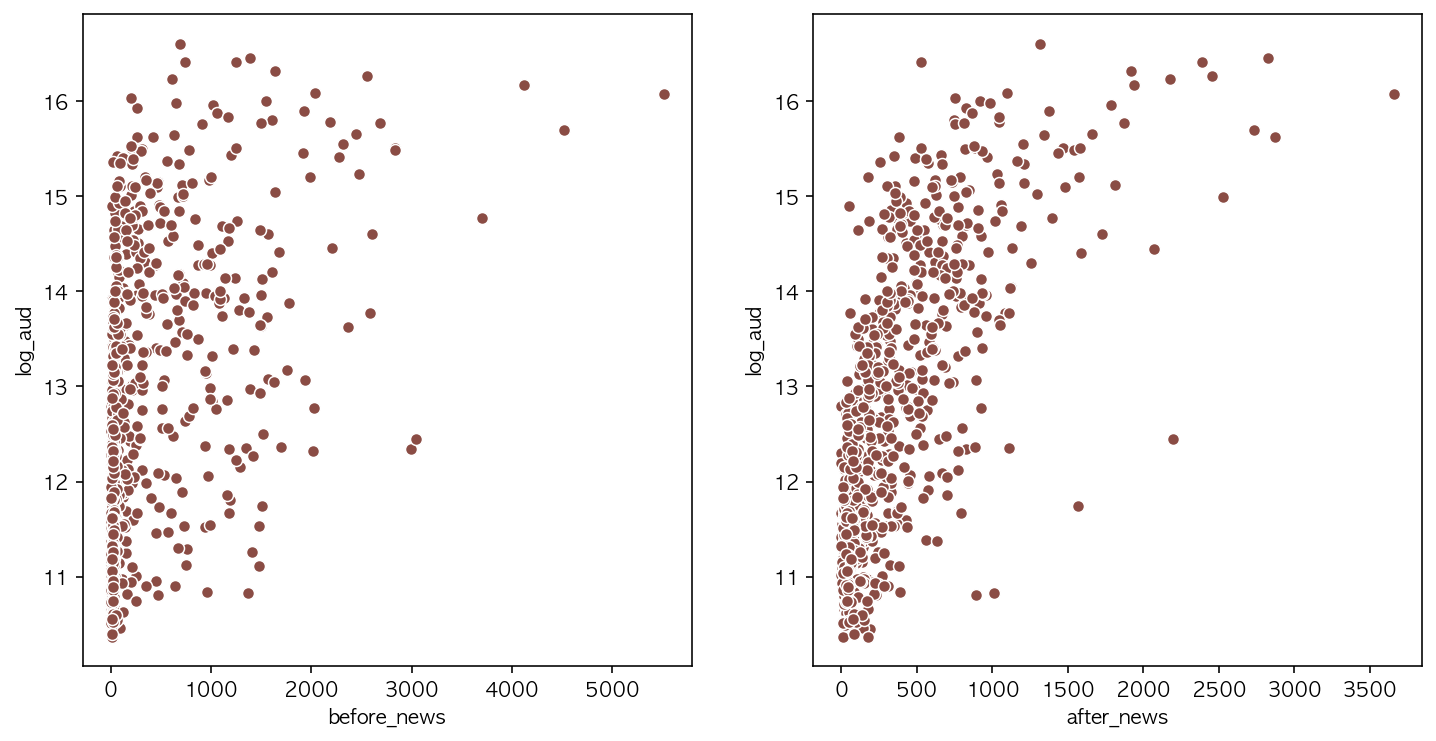

In [286]:
# news 컬럼 변형

plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.scatterplot(x="before_news", y="log_aud", data=df7, color="#8A4C44")
plt.subplot(122)
sns.scatterplot(x="after_news", y="log_aud", data=df7, color="#8A4C44")
plt.show()

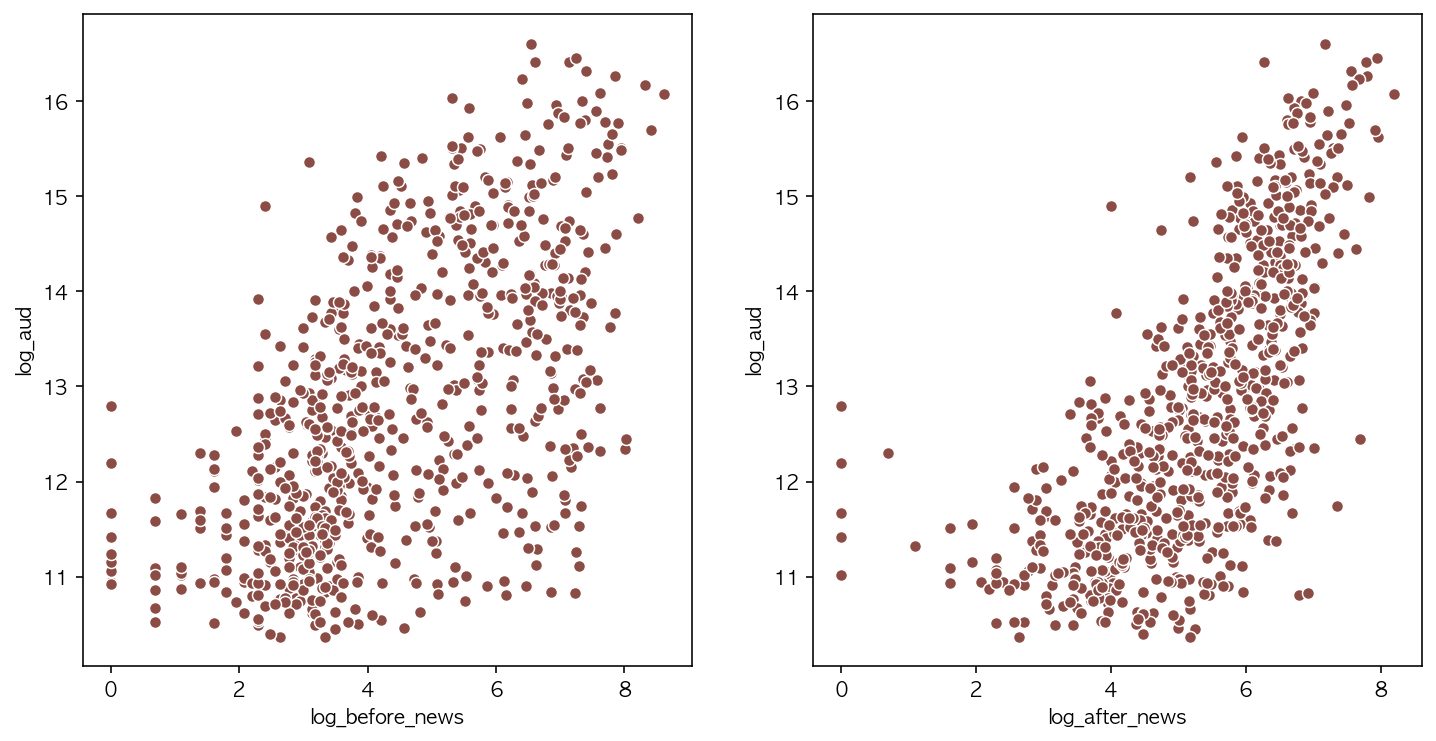

In [287]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.scatterplot(x="log_before_news", y="log_aud", data=df7, color="#8A4C44")
plt.subplot(122)
sns.scatterplot(x="log_after_news", y="log_aud", data=df7, color="#8A4C44")
plt.show()

# model12 => ridge, lasso, elastic 적용
- 미처 제거하지 못한 다중공선성 제거를 위한 정규화
    - Ridge, Lasso, Elastic

In [1185]:
result12_ridge = model12.fit_regularized(alpha=0.01, L1_wt=0, refit=True)
result12_lasso = model12.fit_regularized(alpha=0.01, L1_wt=1, refit=True)

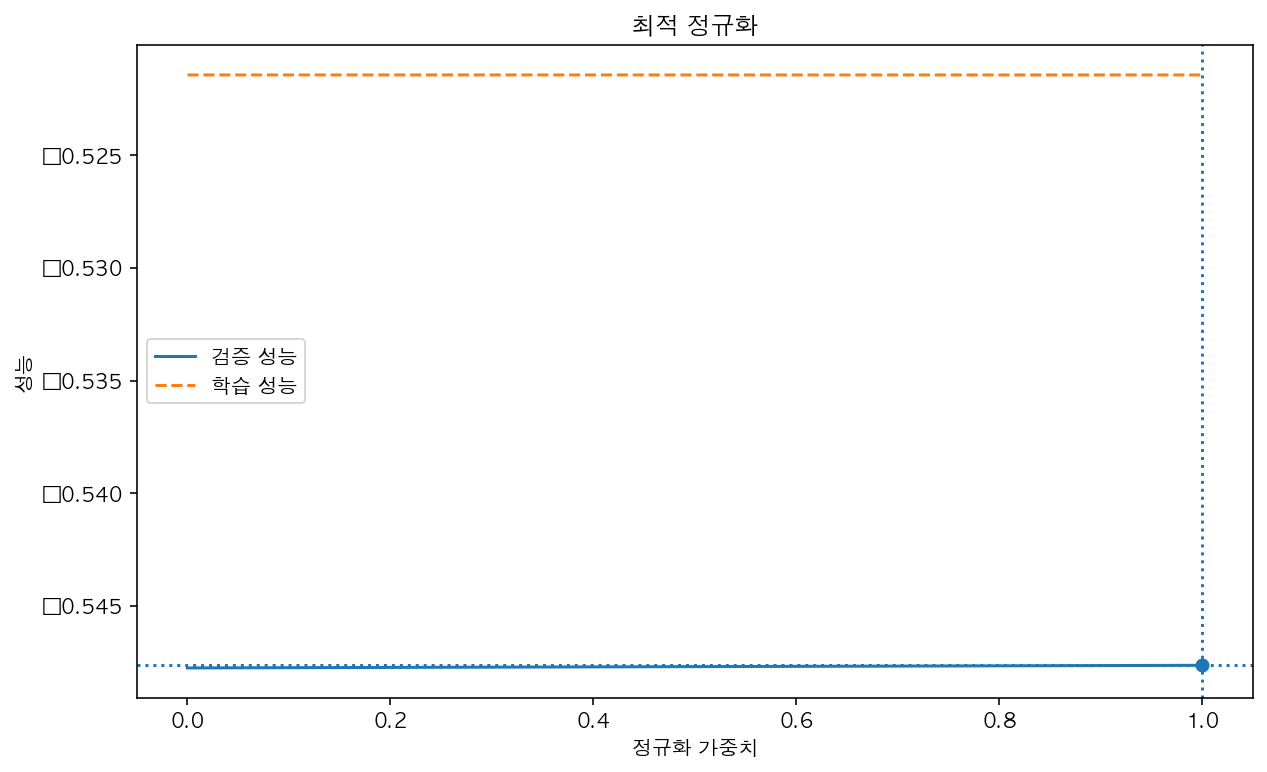

In [1282]:
# Ridge 최적 하이퍼모수 선택

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

alphas = np.logspace(-4, 0, 600)
X = df12[['screen', 'expert_rating', 'actor_power', 'director_power', 'before_news_0to1',
          'after_news_0to1', 'rating_audiences', 'holiday', 'sequel', 'original']]
y = df12['log_aud']

train_scores = []
test_scores = []
for alpha in alphas:
    model = Ridge(alpha=alpha)
    train_score = -mean_squared_error(y, model.fit(X, y).predict(X))
    test_score = np.mean(cross_val_score(
        model, X, y, scoring="neg_mean_squared_error", cv=5))
    train_scores.append(train_score)
    test_scores.append(test_score)

optimal_alpha = alphas[np.argmax(test_scores)]
optimal_score = np.max(test_scores)

plt.figure(figsize=(10, 6))
plt.plot(alphas, test_scores, "-", label="검증 성능")
plt.plot(alphas, train_scores, "--", label="학습 성능")
plt.axhline(optimal_score, linestyle=':')
plt.axvline(optimal_alpha, linestyle=':')
plt.scatter(optimal_alpha, optimal_score)
plt.title("최적 정규화")
plt.ylabel('성능')
plt.xlabel('정규화 가중치')
plt.legend()
plt.show()

In [1283]:
optimal_alpha

1.0

In [1284]:
# kfold 12 - Ridge

from sklearn.model_selection import KFold

kfold_dict_learn['13'] = []
kfold_dict['13'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df12)):
    df_train = df12.iloc[idx_train]
    df_test = df12.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result12_ridge = model.fit_regularized(alpha=0, L1_wt=0, refit=True)

    pred = result12_ridge.predict(df_test[['screen', 'expert_rating', 'actor_power', 'director_power',
                                           'before_news_0to1', 'after_news_0to1', 'rating_audiences', 'holiday', 'sequel', 'original']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict_learn['13'].append(result.rsquared)
    kfold_dict['13'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(0.000000, rsquared))

kfold_dict_avr.append(sum(kfold_dict['13'])/10)

학습 R2 = 0.00000000, 검증 R2 = 0.84993821
학습 R2 = 0.00000000, 검증 R2 = 0.83290446
학습 R2 = 0.00000000, 검증 R2 = 0.85825542
학습 R2 = 0.00000000, 검증 R2 = 0.86068654
학습 R2 = 0.00000000, 검증 R2 = 0.77747769
학습 R2 = 0.00000000, 검증 R2 = 0.83512696
학습 R2 = 0.00000000, 검증 R2 = 0.78946861
학습 R2 = 0.00000000, 검증 R2 = 0.81513469
학습 R2 = 0.00000000, 검증 R2 = 0.84309380
학습 R2 = 0.00000000, 검증 R2 = 0.80922389


In [1285]:
# model12 - Ridge의 테스트 R2

pred = result12_ridge.predict(X_test[['screen', 'expert_rating', 'actor_power', 'director_power',
                                      'before_news_0to1', 'after_news_0to1', 'rating_audiences', 'holiday', 'sequel', 'original']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.82377792449056

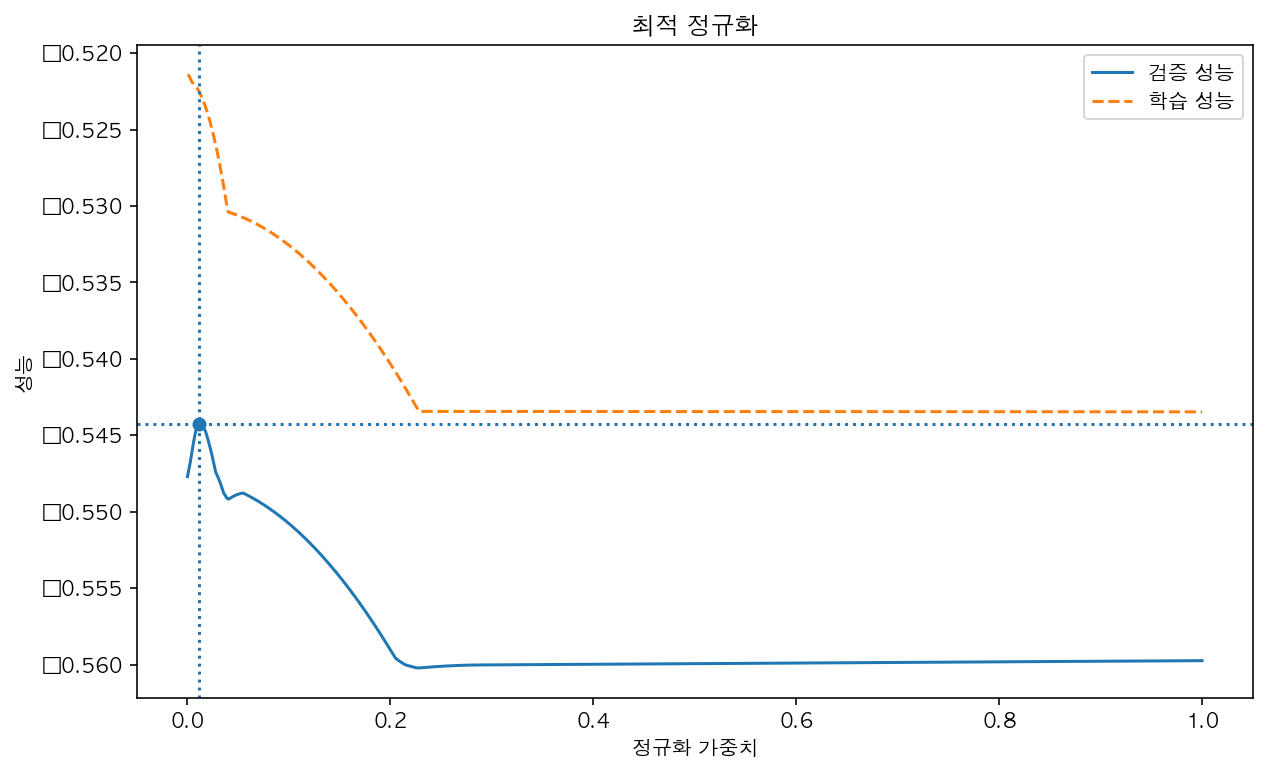

In [1286]:
# Lasso 최적 하이퍼모수 선택

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

alphas = np.logspace(-4, 0, 600)
X = df12[['screen', 'expert_rating', 'actor_power', 'director_power', 'before_news_0to1',
          'after_news_0to1', 'rating_audiences', 'holiday', 'sequel', 'original']]
y = df12['log_aud']

train_scores = []
test_scores = []
for alpha in alphas:
    model = Lasso(alpha=alpha)
    train_score = -mean_squared_error(y, model.fit(X, y).predict(X))
    test_score = np.mean(cross_val_score(
        model, X, y, scoring="neg_mean_squared_error", cv=5))
    train_scores.append(train_score)
    test_scores.append(test_score)

optimal_alpha = alphas[np.argmax(test_scores)]
optimal_score = np.max(test_scores)

plt.figure(figsize=(10, 6))
plt.plot(alphas, test_scores, "-", label="검증 성능")
plt.plot(alphas, train_scores, "--", label="학습 성능")
plt.axhline(optimal_score, linestyle=':')
plt.axvline(optimal_alpha, linestyle=':')
plt.scatter(optimal_alpha, optimal_score)
plt.title("최적 정규화")
plt.ylabel('성능')
plt.xlabel('정규화 가중치')
plt.legend()
plt.show()

In [1287]:
optimal_alpha

0.011051104257708666

In [1288]:
# kfold 12 - Lasso

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

kfold_dict_learn['14'] = []
kfold_dict['14'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df12)):
    df_train = df12.iloc[idx_train]
    df_test = df12.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result12_lasso = model.fit_regularized(alpha=0.01105, L1_wt=1, refit=True)

    pred = result12_lasso.predict(df_test[['screen', 'expert_rating', 'actor_power', 'director_power',
                                           'before_news_0to1', 'after_news_0to1', 'rating_audiences', 'holiday', 'sequel', 'original']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss


#     X = df_train[['screen', 'expert_rating', 'actor_power', 'director_power', 'before_news_0to1',
#           'after_news_0to1', 'rating_audiences', 'holiday', 'sequel', 'original']]
#     y = df_train['log_aud']
#     train_score = mean_squared_error(y, result12_ridge.predict(X))
    scores[i] = rsquared
    kfold_dict_learn['14'].append(result.rsquared)
    kfold_dict['14'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(0.000000, rsquared))

kfold_dict_avr.append(sum(kfold_dict['14'])/10)

학습 R2 = 0.00000000, 검증 R2 = 0.84723427
학습 R2 = 0.00000000, 검증 R2 = 0.83356239
학습 R2 = 0.00000000, 검증 R2 = 0.85808956
학습 R2 = 0.00000000, 검증 R2 = 0.85992716
학습 R2 = 0.00000000, 검증 R2 = 0.77731800
학습 R2 = 0.00000000, 검증 R2 = 0.83699493
학습 R2 = 0.00000000, 검증 R2 = 0.79057799
학습 R2 = 0.00000000, 검증 R2 = 0.81641989
학습 R2 = 0.00000000, 검증 R2 = 0.84291715
학습 R2 = 0.00000000, 검증 R2 = 0.80866932


In [1289]:
# model12 - Lasso의 테스트 R2

pred = result12_lasso.predict(X_test[['screen', 'expert_rating', 'actor_power', 'director_power',
                                      'before_news_0to1', 'after_news_0to1', 'rating_audiences', 'holiday', 'sequel', 'original']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.82387579028221

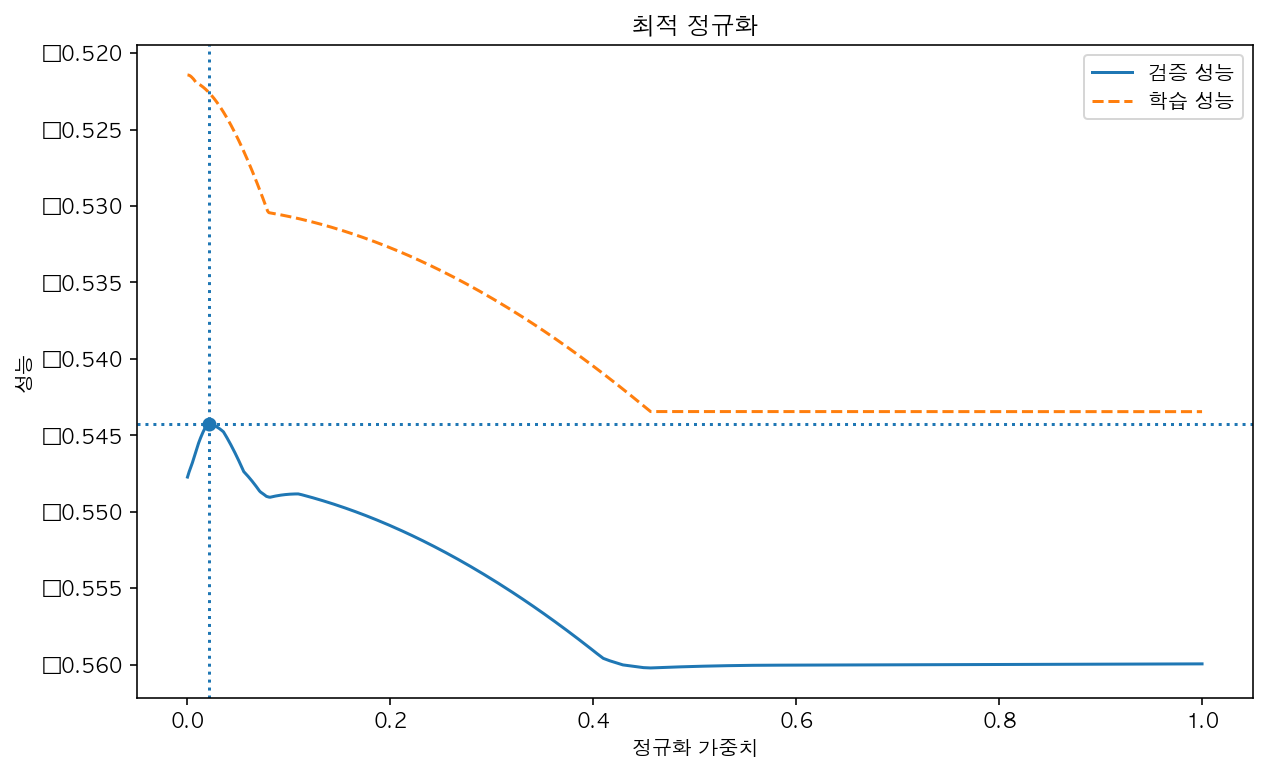

In [1290]:
# ElasticNet 최적 하이퍼모수 선택

from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

alphas = np.logspace(-4, 0, 600)
X = df12[['screen', 'expert_rating', 'actor_power', 'director_power', 'before_news_0to1',
          'after_news_0to1', 'rating_audiences', 'holiday', 'sequel', 'original']]
y = df12['log_aud']

train_scores = []
test_scores = []
for alpha in alphas:
    model = ElasticNet(alpha=alpha)
    train_score = -mean_squared_error(y, model.fit(X, y).predict(X))
    test_score = np.mean(cross_val_score(
        model, X, y, scoring="neg_mean_squared_error", cv=5))
    train_scores.append(train_score)
    test_scores.append(test_score)

optimal_alpha = alphas[np.argmax(test_scores)]
optimal_score = np.max(test_scores)

plt.figure(figsize=(10, 6))
plt.plot(alphas, test_scores, "-", label="검증 성능")
plt.plot(alphas, train_scores, "--", label="학습 성능")
plt.axhline(optimal_score, linestyle=':')
plt.axvline(optimal_alpha, linestyle=':')
plt.scatter(optimal_alpha, optimal_score)
plt.title("최적 정규화")
plt.ylabel('성능')
plt.xlabel('정규화 가중치')
plt.legend()
plt.show()

In [1291]:
optimal_alpha

0.021738456999430788

In [1292]:
# kfold 12 - ElasticNet

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

kfold_dict_learn['15'] = []
kfold_dict['15'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df12)):
    df_train = df12.iloc[idx_train]
    df_test = df12.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result12_elasticnet = model.fit_regularized(
        alpha=0.02174, L1_wt=1, refit=True)

    pred = result12_elasticnet.predict(df_test[['screen', 'expert_rating', 'actor_power', 'director_power',
                                                'before_news_0to1', 'after_news_0to1', 'rating_audiences', 'holiday', 'sequel', 'original']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss


#     X = df_train[['screen', 'expert_rating', 'actor_power', 'director_power', 'before_news_0to1',
#           'after_news_0to1', 'rating_audiences', 'holiday', 'sequel', 'original']]
#     y = df_train['log_aud']
#     train_score = mean_squared_error(y, result12_ridge.predict(X))
    scores[i] = rsquared
    kfold_dict_learn['15'].append(result.rsquared)
    kfold_dict['15'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(0.000000, rsquared))

kfold_dict_avr.append(sum(kfold_dict['15'])/10)

학습 R2 = 0.00000000, 검증 R2 = 0.84578725
학습 R2 = 0.00000000, 검증 R2 = 0.83394414
학습 R2 = 0.00000000, 검증 R2 = 0.85739205
학습 R2 = 0.00000000, 검증 R2 = 0.85722352
학습 R2 = 0.00000000, 검증 R2 = 0.77692480
학습 R2 = 0.00000000, 검증 R2 = 0.83542039
학습 R2 = 0.00000000, 검증 R2 = 0.78870418
학습 R2 = 0.00000000, 검증 R2 = 0.81755014
학습 R2 = 0.00000000, 검증 R2 = 0.84157138
학습 R2 = 0.00000000, 검증 R2 = 0.80845574


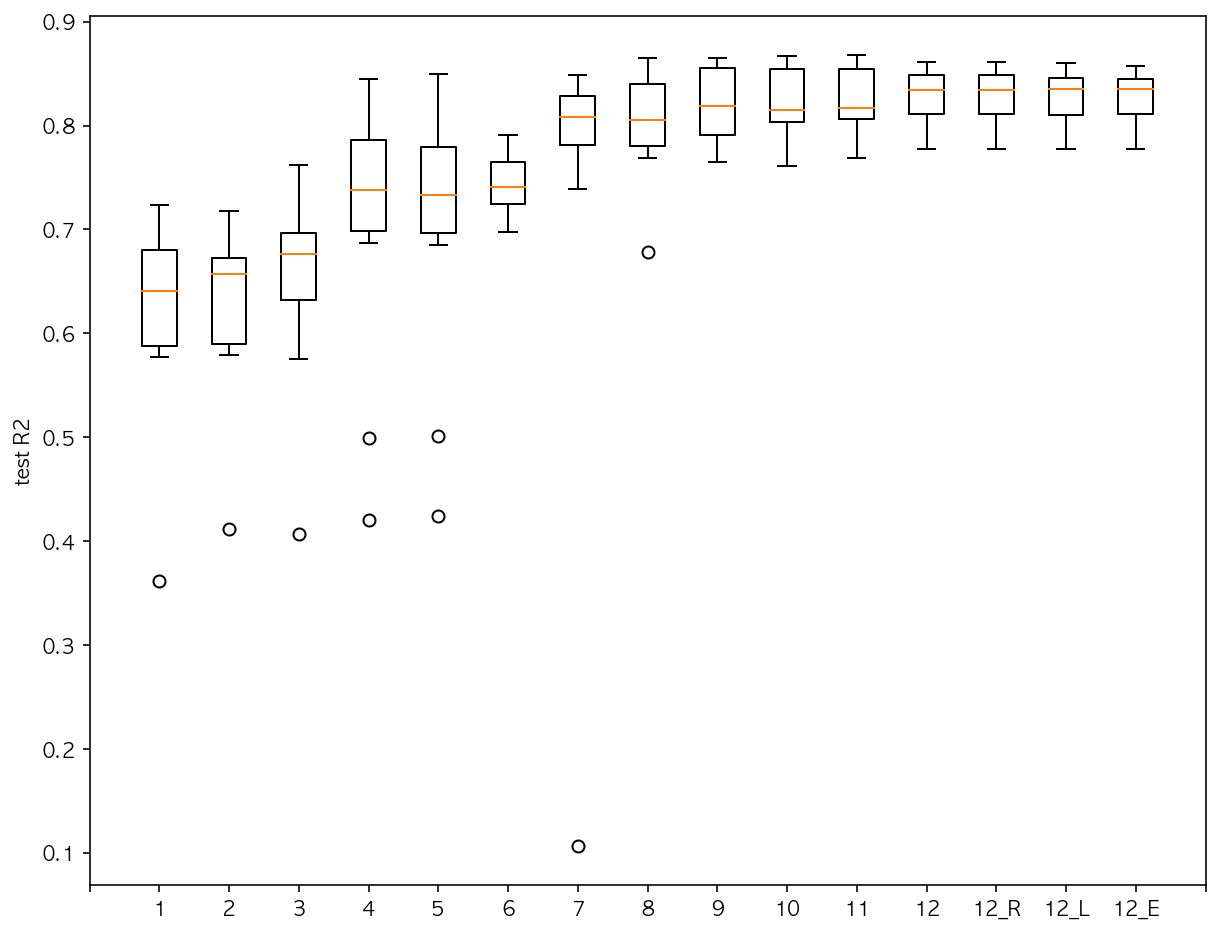

In [1293]:
for i in range(1, len(kfold_dict) + 1):
    kfold_df[str(i)] = kfold_dict[str(i)]

plt.figure(figsize=(10, 8))
plt.boxplot((kfold_df['1'], kfold_df['2'], kfold_df['3'], kfold_df['4'], kfold_df['5'], kfold_df['6'], kfold_df['7'],
             kfold_df['8'], kfold_df['9'], kfold_df['10'], kfold_df['11'], kfold_df['12'], kfold_df['13'], kfold_df['14'], kfold_df['15']))
plt.ylabel("test R2")
plt.xticks(np.arange(17), ('', '1', '2', '3', '4', '5', '6',
                           '7', '8', '9', '10', '11', '12', '12_R', '12_L', '12_E'))

plt.show()